In [1]:
### Prepare module structure ###

import sys
sys.path.append("../")

In [2]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
import data
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

1.0.0


In [3]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:1


In [4]:
### LOAD DATA ###

dataset = 'mnist'
dataloader, imsize = data.load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=256)

In [5]:
def calc_mags(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft ** 2, -1) + 1e-16)
    return mags

### GAN

In [7]:
### LOAD MODEL ####

model_name = "gan784"
z_size = 784

gen = models.FCNet(imsize=(1, 1, z_size), outsize=imsize, h=2048)
# TODO: map storage location to correct GPU!
gen.load_state_dict(torch.load("../cache/models/GAN_MNIST/FCGenerator2048MNIST_{}.sd".format(model_name), map_location={'cuda:1': device.__str__()}));

Version 0.4


In [8]:
# Latent z optimization

def genopt(sample_magn, gen, device, init_x=None, steps=5000, lmd=0.0, lr=1.0):
    
    gen.to(device)
    gen.eval()
    
    if init_x is None:
        # TODO: init like PRCGAN
        #z = torch.randn((sample_magn.shape[0], 1, z_size), requires_grad=True, device=device)
        z = torch.randn((sample_magn.shape[0], z_size), requires_grad=True, device=device)
    else:
        raise NotImplementedError
    
    opt = optim.Adam([z], lr=lr)
    
    losses = []
    errors = []
    last_out = gen(z)
    
    with tqdm(total=steps) as pbar:
        for _ in range(steps):
            magn = calc_mags(last_out)
            error = torch.mean((magn - sample_magn) ** 2, dim=(1, 2, 3))
            regul = torch.sum(z ** 2)
            loss = torch.sum(error) + lmd * regul

            opt.zero_grad()
            loss.backward()
            opt.step()

            last_out = gen(z)

            errors.append(error.detach().cpu().numpy())
            losses.append(loss.item())
            pbar.update()
    
    return last_out.detach().cpu().numpy(), errors

In [10]:
### Latent z optimization ###

num_batches = 1
batch_size = 256
steps = 10000
lmd = 0.0
lr = 1e-3
restarts = 1

###

out_original = np.zeros((batch_size * num_batches, *imsize))
out_results_total = np.zeros((batch_size * num_batches, restarts, *imsize))
errors = np.full((batch_size * num_batches, restarts, steps), np.inf)

with tqdm(total=restarts*num_batches) as pbar:
    for batch_i, batch in enumerate(dataloader['test']):
        test_sample = batch.to(device)
        test_magnitudes = calc_mags(test_sample)   
        out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()
        
        for rix in range(restarts):
            cur_out_results, cur_error = genopt(sample_magn=test_magnitudes, gen=gen, device=device,
                                                          steps=steps, lmd=lmd, lr=lr)

            out_results_total[batch_size * batch_i : batch_size * batch_i + batch_size, rix] = cur_out_results
            errors[batch_size * batch_i : batch_size * batch_i + batch_size, rix] = np.array(cur_error).T

            pbar.update()
        if batch_i + 1 >= num_batches:
            break
            
best_ix = np.argmin(errors[..., -1], axis=-1)
out_results = np.array([out_results_total[i, ix] for i, ix in enumerate(best_ix)])

In [96]:
### CACHE ERRORS ###

import pickle
pickle.dump(errors, open("../cache/err-dpr-{}-{}s-{}b.p".format(model_name, steps, num_batches), "wb"))

In [97]:
### LOAD ERRORS ###
import pickle

errors = pickle.load(open("../cache/err-dpr-{}-{}s-{}b.p".format(model_name, steps, num_batches), "rb"))

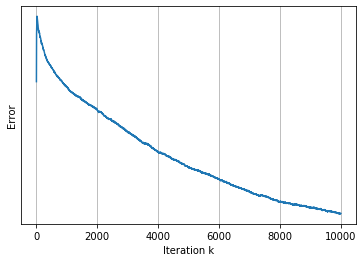

In [98]:
plt.xlabel("Iteration k")
plt.yscale('symlog')
plt.ylabel("Error")
plt.plot(np.mean(errors, axis=(0, 1)))
plt.grid(which='major')
plt.grid(which='minor')
plt.savefig("../out/plots/MNIST_DPR_error-{}-{}s-{}b.png".format(model_name, steps, num_batches), dpi=200)
plt.show()

In [99]:
### CACHE RESULTS ###

import pickle
pickle.dump(out_original, open("../cache/dpr-{}-{}s-{}b_original.p".format(model_name, steps, num_batches), "wb"))
pickle.dump(out_results, open("../cache/dpr-{}-{}s-{}b.p".format(model_name, steps, num_batches), "wb"))

In [100]:
### LOAD RESULTS ###
import pickle

out_original = pickle.load(open("../cache/dpr-{}-{}s-{}b_original.p".format(model_name, steps, num_batches), "rb"))
out_results = pickle.load(open("../cache/dpr-{}-{}s-{}b.p".format(model_name, steps, num_batches), "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


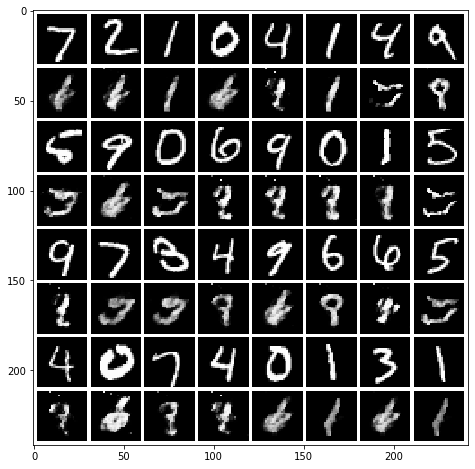

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Registered:


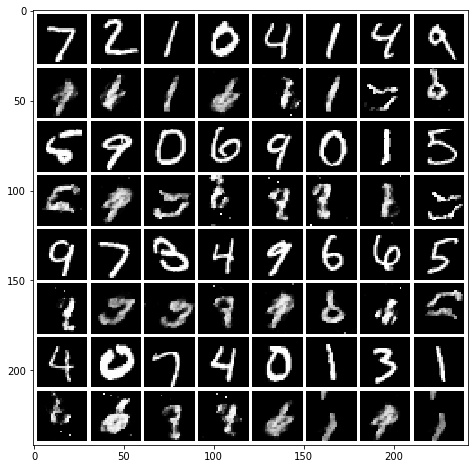

In [101]:
# Print predictions #
to_plot = np.stack([out_original[:32, 0].reshape(4, 8, 28, 28), 
                    out_results[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
plot_grid(to_plot, figsize=(8,8),file="../out/MNIST/generative-prior/dpr-{}-{}s-{}b.png"\
          .format(model_name, steps, num_batches))

print("Registered:")
results_reg = register_croco(out_results[:32], out_original[:32])
to_plot = np.stack([out_original[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)        
plot_grid(to_plot, figsize=(8,8), file="../out/MNIST/generative-prior/dpr-{}-{}s-{}b-reg.png"\
          .format(model_name, steps, num_batches))

In [11]:
# Benchmark test predictions #

benchmark(pred=out_results[:1024], true=out_original[:1024], check_all=True)

Signal error:
  MSE: 0.10184050869731309, std: 0.036852364302262325
  MAE: 0.13658149217416252, std: 0.04042249269644308
  SSIM: 0.2867491783614795, std: 0.16056397858952218
  Sharpness: 0.15649656904975118, std: 0.035875381359740194
  PhCo-MSE: 0.09211149115818011, std: 0.039887869111087916
  PhCo-MAE: 0.12622385250969245, std: 0.044119184291212775
  PhCo-SSIM: 0.3820150344945134, std: 0.14623504374228158
  CroCo-MSE: 0.07091644593540553, std: 0.02845411454252226
  CroCo-MAE: 0.10382035376217522, std: 0.032792219814323016
  CroCo-SSIM: 0.4632965261193755, std: 0.1249768990495563

Magnitude error:
  MSE Magnitude: 16.857654846308492, std: 8.376275329952762

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.1018 | 0.1366 | 0.2867 | 0.1565 | 0.09211 | 0.1262 | 0.3820 | 0.07092 | 0.1038 | 0.4633 | 16.86 |


In [4]:
9.74669327637752 / 32

0.3045841648867975

# GAN

### dim(z) = 784

| steps | lr | reg | MSE | MAE | SSIM | SHRP | PhCo-MSE | PhCo-MAE | PhCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 10000 | 0.1 | - | 0.1046 | 0.1319 | 0.3147 | 0.1593 | 0.09568 | 0.1226 | 0.3989 | 0.07119 | 0.09730 | 0.4903 | 14.90 |

Signal error:
  MSE: 0.10458389184028594, std: 0.04175727061837974
  MAE: 0.13186028798458233, std: 0.04561482732451085
  SSIM: 0.31467870470007786, std: 0.19518438304668428
  Sharpness: 0.15927334863556913, std: 0.04162758159857612
  PhCo-MSE: 0.0956801217910932, std: 0.042609812581810604
  PhCo-MAE: 0.1226177483027133, std: 0.04707974850200637
  PhCo-SSIM: 0.3988656659679032, std: 0.17188191729195418
  CroCo-MSE: 0.07119220309115734, std: 0.028707652998801264
  CroCo-MAE: 0.097299231707412, std: 0.03303099757433888
  CroCo-SSIM: 0.4903235996742026, std: 0.15096890773728422

Magnitude error:
  MSE Magnitude: 14.90462156950709, std: 6.422326579128158

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

### dim(z) = 128

| steps | lr | reg | MSE | MAE | SSIM | SHRP | PhCo-MSE | PhCo-MAE | PhCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
| 10000 | 0.1 | - | 0.09625 | 0.1278 | 0.3263 | 0.1572 | 0.08680 | 0.1177 | 0.4191 | 0.06568 | 0.09564 | 0.4954 | 14.45 |

Signal error:
  MSE: 0.09625003910358751, std: 0.0384411011648786
  MAE: 0.12781503933743904, std: 0.043669535800792116
  SSIM: 0.32625670714007804, std: 0.18951627998419968
  Sharpness: 0.15715570774033039, std: 0.040265922676286175
  PhCo-MSE: 0.08680099303219262, std: 0.03927845133365525
  PhCo-MAE: 0.11771192403525889, std: 0.04454799400743285
  PhCo-SSIM: 0.4191022143563431, std: 0.15874313560786152
  CroCo-MSE: 0.06567660635345127, std: 0.026007755342627788
  CroCo-MAE: 0.09563851310089136, std: 0.031251651521254815
  CroCo-SSIM: 0.49544556239543286, std: 0.13020471112271573

Magnitude error:
  MSE Magnitude: 14.447550023195603, std: 6.443890085303635

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

# GAN + MAE

### dim(z) = 784

| steps | lr | reg | MSE | MAE | SSIM | SHRP | PhCo-MSE | PhCo-MAE | PhCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 10000 | 0.1 | - | 0.09340 | 0.1315 | 0.2995 | 0.1508 | 0.09010 | 0.1283 | 0.3698 | 0.06702 | 0.1032 | 0.4579 | 18.50 |

Signal error:
  MSE: 0.09340366471448627, std: 0.038699665940653605
  MAE: 0.13148393466673342, std: 0.04442650713739514
  SSIM: 0.29949231035484775, std: 0.1925319472766557
  Sharpness: 0.15075657526249783, std: 0.03852202927385449
  PhCo-MSE: 0.09009914425693422, std: 0.04235673647102389
  PhCo-MAE: 0.12830318133084848, std: 0.04923619961904969
  PhCo-SSIM: 0.3698046975461163, std: 0.16652463860506972
  CroCo-MSE: 0.06701582539432599, std: 0.029059962307396506
  CroCo-MAE: 0.10319101103489571, std: 0.03555199972326804
  CroCo-SSIM: 0.4578743230948502, std: 0.14774749523634317

Magnitude error:
  MSE Magnitude: 18.502079146823867, std: 9.74669327637752

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

### dim(z) = 128

| steps | lr | reg | MSE | MAE | SSIM | SHRP | PhCo-MSE | PhCo-MAE | PhCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 10000 | 0.1 | - | 

In [1]:
9.74669327637752 / 32

0.3045841648867975

# VAE

### Train

---

In [101]:
### LOAD DATA ###

dataset = 'mnist'
trainloader, imsize = data.load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=32)
trainloader = trainloader['train']

In [7]:
# Encoder for real valued signals
class SignalEncoder(nn.Module):
    
    def __init__(self, shape=(1,28,28), latent_dim=20, hidden_dim=500, mean=None, std=None):
        super(SignalEncoder, self).__init__()
        
        self.latent_dim = latent_dim
        self.in_dim = np.prod(np.array(shape))
        self.hidden_dim = hidden_dim
        
        if mean is None:
            self.register_buffer('mean', torch.zeros(shape))
        else:
            self.register_buffer('mean', torch.Tensor(mean))

        if std is None:
            self.register_buffer('std', torch.ones(shape))
        else:
            self.register_buffer('std', torch.Tensor(std))
        
        self.fc_hidden = nn.Sequential(
            nn.Linear(self.in_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(self.hidden_dim, latent_dim)
        self.fc_sigma = nn.Linear(self.hidden_dim, latent_dim)

    def forward(self, x):
        N = x.shape[0]

        x_norm = (x - self.mean) / self.std

        hidden_state = self.fc_hidden(x_norm.view(N, self.in_dim))
        mu , sigma = self.fc_mu(hidden_state), torch.exp(0.5 * self.fc_sigma(hidden_state))
        
        return mu, sigma


# Decoder for real valued signals        
class SignalDecoder(nn.Module):
    
    def __init__(self, shape=(1,28,28), latent_dim=20, hidden_dim=500):
        super(SignalDecoder, self).__init__()
        
        self.shape = shape
        self.out_dim = np.prod(np.array(shape))
        self.hidden_dim = hidden_dim
        
        self.layers = nn.Sequential(
            nn.Linear(latent_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.out_dim),
            nn.Sigmoid()
        )
        
    def forward(self, z):
        N = z.shape[0]
        return self.layers(z).view(N, *self.shape)


# VAE combining SignalEncoder and SignalDecoder that samples latent vector z from N(mu, sigma) in training
class SignalVAE(nn.Module):
    
    def __init__(self, shape=(1,28,28), latent_dim=392, hidden_dim=500, mean=None, std=None):
        super(SignalVAE, self).__init__()
        
        print("Version 4")
        
        self.encoder = SignalEncoder(shape=shape, latent_dim=latent_dim, hidden_dim=hidden_dim, mean=None, std=None)
        self.decoder = SignalDecoder(shape=shape, latent_dim=latent_dim, hidden_dim=hidden_dim)
        
    def sample(self, mu, sigma):
        noise = torch.randn_like(sigma)
        
        return mu + noise * sigma
        
    def forward(self, x):
        z_mu, z_sigma = self.encoder(x)
        
        if self.training:
            z = self.sample(z_mu, z_sigma)
        else:
            z = z_mu
        
        return self.decoder(z), z_mu, z_sigma

In [125]:
### DEFINE MODEL ###

latent_dim = 128

vae = SignalVAE(shape=imsize, latent_dim=latent_dim, hidden_dim=2048)

Version 4


In [126]:
def loss(out_image, in_image, alpha=2.0):
    return torch.mean(torch.abs(out_image - in_image) ** alpha)

def reg(mu, sigma):
    return torch.mean(sigma ** 2 + mu ** 2 - 2 * torch.log(sigma) - 1)

In [127]:
# Set training parameters

alpha_loss = 2.0
gamma = 1e-3 # 1e-3

history = []
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [128]:
def train_model(model, optimizer, device, loader_train, epochs=1):
    """
    Train a model
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - device: The device to perform computation on
    - load_train: The DataLoader object to feed the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Loss history per iteration step
    """
    # move the model parameters to CPU/GPU
    model = model.to(device=device)
    
    for e in range(epochs):

        for t, x in enumerate(loader_train):
            # put model to training mode
            model.train()
            
            # move x to device and reduce to magnitude information in fourier space
            x = x.to(device=device)

            # compute loss as pixel wise distance to original input
            out_recon, out_mu, out_sigma = model(x)
            
            #loss = 
            reg_loss = gamma * reg(mu=out_mu, sigma=out_sigma)
            total_loss = loss(out_image=out_recon, in_image=x, alpha=alpha_loss) + reg_loss
            history.append(total_loss.item())

            # perform backprop and learning step
            optimizer.zero_grad()
            total_loss.backward() 
            optimizer.step()

            if t % 100 == 0:
                print("epoch: {:2} \t step:{} \t loss: {:3.4} \t reg loss: {:3.4}".format(e+1, t, history[-1], reg_loss))
                
        plt.plot(history[-10000:])
        plt.show()
                
                
    return history

epoch:  1 	 step:0 	 loss: 0.2333 	 reg loss: 1.366e-05
epoch:  1 	 step:100 	 loss: 0.0412 	 reg loss: 0.001299
epoch:  1 	 step:200 	 loss: 0.04233 	 reg loss: 0.00134
epoch:  1 	 step:300 	 loss: 0.03829 	 reg loss: 0.00144
epoch:  1 	 step:400 	 loss: 0.03533 	 reg loss: 0.001418
epoch:  1 	 step:500 	 loss: 0.03139 	 reg loss: 0.001416
epoch:  1 	 step:600 	 loss: 0.03386 	 reg loss: 0.001285
epoch:  1 	 step:700 	 loss: 0.03059 	 reg loss: 0.001306
epoch:  1 	 step:800 	 loss: 0.03281 	 reg loss: 0.001269
epoch:  1 	 step:900 	 loss: 0.03097 	 reg loss: 0.001257
epoch:  1 	 step:1000 	 loss: 0.03241 	 reg loss: 0.001227
epoch:  1 	 step:1100 	 loss: 0.03176 	 reg loss: 0.001233
epoch:  1 	 step:1200 	 loss: 0.0256 	 reg loss: 0.001191
epoch:  1 	 step:1300 	 loss: 0.03243 	 reg loss: 0.001228
epoch:  1 	 step:1400 	 loss: 0.03264 	 reg loss: 0.001169
epoch:  1 	 step:1500 	 loss: 0.02316 	 reg loss: 0.001182
epoch:  1 	 step:1600 	 loss: 0.0284 	 reg loss: 0.001202
epoch:  1 	 st

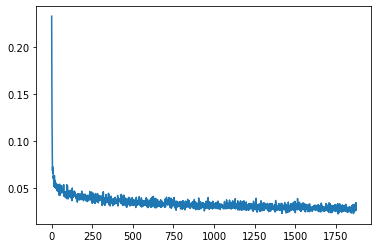

epoch:  2 	 step:0 	 loss: 0.03005 	 reg loss: 0.001166
epoch:  2 	 step:100 	 loss: 0.02952 	 reg loss: 0.001199
epoch:  2 	 step:200 	 loss: 0.02455 	 reg loss: 0.001164
epoch:  2 	 step:300 	 loss: 0.0278 	 reg loss: 0.001169
epoch:  2 	 step:400 	 loss: 0.02372 	 reg loss: 0.001169
epoch:  2 	 step:500 	 loss: 0.02572 	 reg loss: 0.001162
epoch:  2 	 step:600 	 loss: 0.02444 	 reg loss: 0.001163
epoch:  2 	 step:700 	 loss: 0.02915 	 reg loss: 0.001191
epoch:  2 	 step:800 	 loss: 0.02451 	 reg loss: 0.001132
epoch:  2 	 step:900 	 loss: 0.0264 	 reg loss: 0.001152
epoch:  2 	 step:1000 	 loss: 0.02452 	 reg loss: 0.001092
epoch:  2 	 step:1100 	 loss: 0.02654 	 reg loss: 0.001165
epoch:  2 	 step:1200 	 loss: 0.02517 	 reg loss: 0.001085
epoch:  2 	 step:1300 	 loss: 0.02601 	 reg loss: 0.0011
epoch:  2 	 step:1400 	 loss: 0.02402 	 reg loss: 0.001122
epoch:  2 	 step:1500 	 loss: 0.02644 	 reg loss: 0.001067
epoch:  2 	 step:1600 	 loss: 0.02426 	 reg loss: 0.001105
epoch:  2 	 s

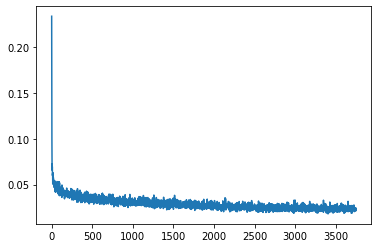

epoch:  3 	 step:0 	 loss: 0.02303 	 reg loss: 0.001073
epoch:  3 	 step:100 	 loss: 0.02514 	 reg loss: 0.001055
epoch:  3 	 step:200 	 loss: 0.02083 	 reg loss: 0.001038
epoch:  3 	 step:300 	 loss: 0.02308 	 reg loss: 0.00104
epoch:  3 	 step:400 	 loss: 0.02172 	 reg loss: 0.001014
epoch:  3 	 step:500 	 loss: 0.02172 	 reg loss: 0.001002
epoch:  3 	 step:600 	 loss: 0.01996 	 reg loss: 0.000991
epoch:  3 	 step:700 	 loss: 0.02461 	 reg loss: 0.00103
epoch:  3 	 step:800 	 loss: 0.02158 	 reg loss: 0.001027
epoch:  3 	 step:900 	 loss: 0.02355 	 reg loss: 0.001026
epoch:  3 	 step:1000 	 loss: 0.01996 	 reg loss: 0.0009726
epoch:  3 	 step:1100 	 loss: 0.02134 	 reg loss: 0.001017
epoch:  3 	 step:1200 	 loss: 0.02013 	 reg loss: 0.001015
epoch:  3 	 step:1300 	 loss: 0.02053 	 reg loss: 0.001002
epoch:  3 	 step:1400 	 loss: 0.02254 	 reg loss: 0.001005
epoch:  3 	 step:1500 	 loss: 0.02122 	 reg loss: 0.001039
epoch:  3 	 step:1600 	 loss: 0.02326 	 reg loss: 0.001022
epoch:  3 

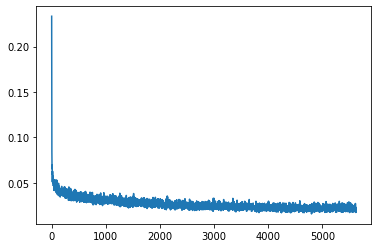

epoch:  4 	 step:0 	 loss: 0.02641 	 reg loss: 0.00102
epoch:  4 	 step:100 	 loss: 0.02165 	 reg loss: 0.00102
epoch:  4 	 step:200 	 loss: 0.01671 	 reg loss: 0.0009715
epoch:  4 	 step:300 	 loss: 0.01933 	 reg loss: 0.0009526
epoch:  4 	 step:400 	 loss: 0.0177 	 reg loss: 0.0009392
epoch:  4 	 step:500 	 loss: 0.02069 	 reg loss: 0.0009646
epoch:  4 	 step:600 	 loss: 0.02195 	 reg loss: 0.0009577
epoch:  4 	 step:700 	 loss: 0.02109 	 reg loss: 0.0009526
epoch:  4 	 step:800 	 loss: 0.01835 	 reg loss: 0.0009225
epoch:  4 	 step:900 	 loss: 0.02016 	 reg loss: 0.0009626
epoch:  4 	 step:1000 	 loss: 0.02179 	 reg loss: 0.0009371
epoch:  4 	 step:1100 	 loss: 0.02448 	 reg loss: 0.0009586
epoch:  4 	 step:1200 	 loss: 0.01894 	 reg loss: 0.0009271
epoch:  4 	 step:1300 	 loss: 0.02007 	 reg loss: 0.000965
epoch:  4 	 step:1400 	 loss: 0.02158 	 reg loss: 0.0009101
epoch:  4 	 step:1500 	 loss: 0.02278 	 reg loss: 0.0009647
epoch:  4 	 step:1600 	 loss: 0.02126 	 reg loss: 0.000928

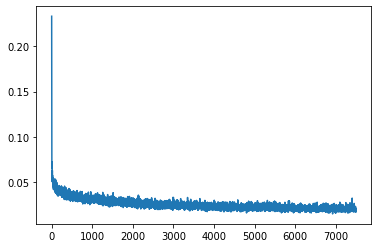

epoch:  5 	 step:0 	 loss: 0.01896 	 reg loss: 0.0009182
epoch:  5 	 step:100 	 loss: 0.01864 	 reg loss: 0.0009259
epoch:  5 	 step:200 	 loss: 0.02167 	 reg loss: 0.00092
epoch:  5 	 step:300 	 loss: 0.02007 	 reg loss: 0.0009292
epoch:  5 	 step:400 	 loss: 0.02229 	 reg loss: 0.0009456
epoch:  5 	 step:500 	 loss: 0.01863 	 reg loss: 0.0009078
epoch:  5 	 step:600 	 loss: 0.02438 	 reg loss: 0.0009706
epoch:  5 	 step:700 	 loss: 0.01543 	 reg loss: 0.0009286
epoch:  5 	 step:800 	 loss: 0.02093 	 reg loss: 0.0009537
epoch:  5 	 step:900 	 loss: 0.01772 	 reg loss: 0.0009086
epoch:  5 	 step:1000 	 loss: 0.01902 	 reg loss: 0.0009111
epoch:  5 	 step:1100 	 loss: 0.01816 	 reg loss: 0.0009134
epoch:  5 	 step:1200 	 loss: 0.01764 	 reg loss: 0.0009196
epoch:  5 	 step:1300 	 loss: 0.0186 	 reg loss: 0.0009043
epoch:  5 	 step:1400 	 loss: 0.01769 	 reg loss: 0.0009235
epoch:  5 	 step:1500 	 loss: 0.0212 	 reg loss: 0.0009005
epoch:  5 	 step:1600 	 loss: 0.01928 	 reg loss: 0.0008

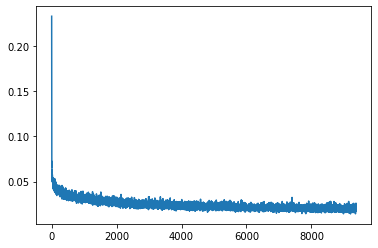

epoch:  6 	 step:0 	 loss: 0.01779 	 reg loss: 0.0008911
epoch:  6 	 step:100 	 loss: 0.01763 	 reg loss: 0.0008734
epoch:  6 	 step:200 	 loss: 0.01743 	 reg loss: 0.0008733
epoch:  6 	 step:300 	 loss: 0.02768 	 reg loss: 0.0009188
epoch:  6 	 step:400 	 loss: 0.01971 	 reg loss: 0.0008848
epoch:  6 	 step:500 	 loss: 0.01721 	 reg loss: 0.0008857
epoch:  6 	 step:600 	 loss: 0.01874 	 reg loss: 0.0008596
epoch:  6 	 step:700 	 loss: 0.01843 	 reg loss: 0.0009154
epoch:  6 	 step:800 	 loss: 0.01605 	 reg loss: 0.000909
epoch:  6 	 step:900 	 loss: 0.01812 	 reg loss: 0.0008999
epoch:  6 	 step:1000 	 loss: 0.02127 	 reg loss: 0.0008972
epoch:  6 	 step:1100 	 loss: 0.02077 	 reg loss: 0.0009009
epoch:  6 	 step:1200 	 loss: 0.01858 	 reg loss: 0.0008682
epoch:  6 	 step:1300 	 loss: 0.01682 	 reg loss: 0.0008735
epoch:  6 	 step:1400 	 loss: 0.01368 	 reg loss: 0.0009017
epoch:  6 	 step:1500 	 loss: 0.01854 	 reg loss: 0.0008868
epoch:  6 	 step:1600 	 loss: 0.01779 	 reg loss: 0.0

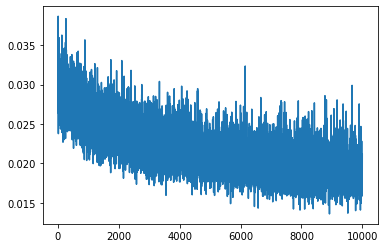

epoch:  7 	 step:0 	 loss: 0.01485 	 reg loss: 0.0008695
epoch:  7 	 step:100 	 loss: 0.01604 	 reg loss: 0.0008627
epoch:  7 	 step:200 	 loss: 0.01989 	 reg loss: 0.0009183
epoch:  7 	 step:300 	 loss: 0.02145 	 reg loss: 0.0008962
epoch:  7 	 step:400 	 loss: 0.01884 	 reg loss: 0.0008824
epoch:  7 	 step:500 	 loss: 0.02321 	 reg loss: 0.0009085
epoch:  7 	 step:600 	 loss: 0.01843 	 reg loss: 0.0008839
epoch:  7 	 step:700 	 loss: 0.01698 	 reg loss: 0.0008609
epoch:  7 	 step:800 	 loss: 0.02091 	 reg loss: 0.0008699
epoch:  7 	 step:900 	 loss: 0.01698 	 reg loss: 0.0008615
epoch:  7 	 step:1000 	 loss: 0.01986 	 reg loss: 0.0008673
epoch:  7 	 step:1100 	 loss: 0.01897 	 reg loss: 0.0008709
epoch:  7 	 step:1200 	 loss: 0.01886 	 reg loss: 0.0008796
epoch:  7 	 step:1300 	 loss: 0.01879 	 reg loss: 0.0008577
epoch:  7 	 step:1400 	 loss: 0.01795 	 reg loss: 0.0008628
epoch:  7 	 step:1500 	 loss: 0.02094 	 reg loss: 0.000871
epoch:  7 	 step:1600 	 loss: 0.01942 	 reg loss: 0.0

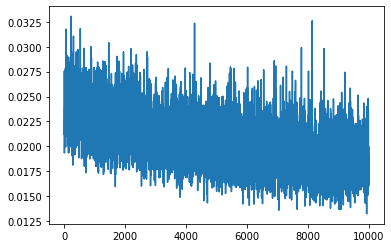

epoch:  8 	 step:0 	 loss: 0.01781 	 reg loss: 0.0008539
epoch:  8 	 step:100 	 loss: 0.01685 	 reg loss: 0.0008654
epoch:  8 	 step:200 	 loss: 0.01812 	 reg loss: 0.0008629
epoch:  8 	 step:300 	 loss: 0.01803 	 reg loss: 0.0008678
epoch:  8 	 step:400 	 loss: 0.01667 	 reg loss: 0.0008654
epoch:  8 	 step:500 	 loss: 0.01733 	 reg loss: 0.0008583
epoch:  8 	 step:600 	 loss: 0.01674 	 reg loss: 0.0008378
epoch:  8 	 step:700 	 loss: 0.01882 	 reg loss: 0.0008402
epoch:  8 	 step:800 	 loss: 0.02336 	 reg loss: 0.0009033
epoch:  8 	 step:900 	 loss: 0.01824 	 reg loss: 0.0008557
epoch:  8 	 step:1000 	 loss: 0.01387 	 reg loss: 0.0008451
epoch:  8 	 step:1100 	 loss: 0.02047 	 reg loss: 0.0008941
epoch:  8 	 step:1200 	 loss: 0.02023 	 reg loss: 0.0008938
epoch:  8 	 step:1300 	 loss: 0.01674 	 reg loss: 0.0008599
epoch:  8 	 step:1400 	 loss: 0.01702 	 reg loss: 0.0008401
epoch:  8 	 step:1500 	 loss: 0.01903 	 reg loss: 0.0008697
epoch:  8 	 step:1600 	 loss: 0.01711 	 reg loss: 0.

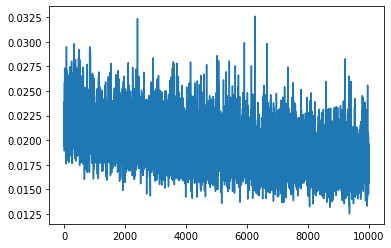

epoch:  9 	 step:0 	 loss: 0.0174 	 reg loss: 0.000851
epoch:  9 	 step:100 	 loss: 0.01624 	 reg loss: 0.0008639
epoch:  9 	 step:200 	 loss: 0.01957 	 reg loss: 0.0008887
epoch:  9 	 step:300 	 loss: 0.02037 	 reg loss: 0.0008417
epoch:  9 	 step:400 	 loss: 0.01972 	 reg loss: 0.0008815
epoch:  9 	 step:500 	 loss: 0.01899 	 reg loss: 0.000864
epoch:  9 	 step:600 	 loss: 0.01491 	 reg loss: 0.0008561
epoch:  9 	 step:700 	 loss: 0.01515 	 reg loss: 0.000867
epoch:  9 	 step:800 	 loss: 0.01652 	 reg loss: 0.0008543
epoch:  9 	 step:900 	 loss: 0.01718 	 reg loss: 0.0008628
epoch:  9 	 step:1000 	 loss: 0.01808 	 reg loss: 0.0008746
epoch:  9 	 step:1100 	 loss: 0.01787 	 reg loss: 0.0008792
epoch:  9 	 step:1200 	 loss: 0.01608 	 reg loss: 0.0008532
epoch:  9 	 step:1300 	 loss: 0.015 	 reg loss: 0.0008663
epoch:  9 	 step:1400 	 loss: 0.01744 	 reg loss: 0.0008811
epoch:  9 	 step:1500 	 loss: 0.01743 	 reg loss: 0.0008757
epoch:  9 	 step:1600 	 loss: 0.0145 	 reg loss: 0.0008804

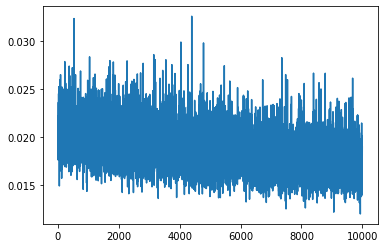

epoch: 10 	 step:0 	 loss: 0.01834 	 reg loss: 0.0008922
epoch: 10 	 step:100 	 loss: 0.0152 	 reg loss: 0.0008641
epoch: 10 	 step:200 	 loss: 0.01679 	 reg loss: 0.0008877
epoch: 10 	 step:300 	 loss: 0.01619 	 reg loss: 0.0009115
epoch: 10 	 step:400 	 loss: 0.01846 	 reg loss: 0.0008865
epoch: 10 	 step:500 	 loss: 0.01612 	 reg loss: 0.0009116
epoch: 10 	 step:600 	 loss: 0.0154 	 reg loss: 0.000895
epoch: 10 	 step:700 	 loss: 0.0144 	 reg loss: 0.0008858
epoch: 10 	 step:800 	 loss: 0.01669 	 reg loss: 0.0009455
epoch: 10 	 step:900 	 loss: 0.01603 	 reg loss: 0.000908
epoch: 10 	 step:1000 	 loss: 0.01592 	 reg loss: 0.0008885
epoch: 10 	 step:1100 	 loss: 0.01721 	 reg loss: 0.0008986
epoch: 10 	 step:1200 	 loss: 0.01675 	 reg loss: 0.000875
epoch: 10 	 step:1300 	 loss: 0.01715 	 reg loss: 0.0008785
epoch: 10 	 step:1400 	 loss: 0.01845 	 reg loss: 0.0009509
epoch: 10 	 step:1500 	 loss: 0.01351 	 reg loss: 0.000877
epoch: 10 	 step:1600 	 loss: 0.01535 	 reg loss: 0.0008701

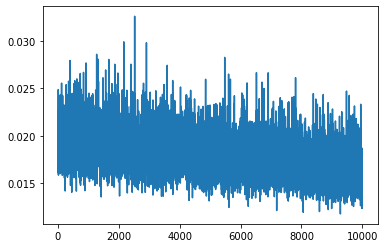

epoch: 11 	 step:0 	 loss: 0.01428 	 reg loss: 0.000863
epoch: 11 	 step:100 	 loss: 0.0164 	 reg loss: 0.000868
epoch: 11 	 step:200 	 loss: 0.01758 	 reg loss: 0.000879
epoch: 11 	 step:300 	 loss: 0.01684 	 reg loss: 0.000863
epoch: 11 	 step:400 	 loss: 0.0164 	 reg loss: 0.0008718
epoch: 11 	 step:500 	 loss: 0.01512 	 reg loss: 0.0008907
epoch: 11 	 step:600 	 loss: 0.01916 	 reg loss: 0.0008891
epoch: 11 	 step:700 	 loss: 0.01562 	 reg loss: 0.0008644
epoch: 11 	 step:800 	 loss: 0.01644 	 reg loss: 0.0008688
epoch: 11 	 step:900 	 loss: 0.01571 	 reg loss: 0.0008546
epoch: 11 	 step:1000 	 loss: 0.01622 	 reg loss: 0.0008864
epoch: 11 	 step:1100 	 loss: 0.01637 	 reg loss: 0.0008533
epoch: 11 	 step:1200 	 loss: 0.0166 	 reg loss: 0.0008532
epoch: 11 	 step:1300 	 loss: 0.01728 	 reg loss: 0.0008819
epoch: 11 	 step:1400 	 loss: 0.01516 	 reg loss: 0.0008724
epoch: 11 	 step:1500 	 loss: 0.01693 	 reg loss: 0.0009431
epoch: 11 	 step:1600 	 loss: 0.0137 	 reg loss: 0.0008422


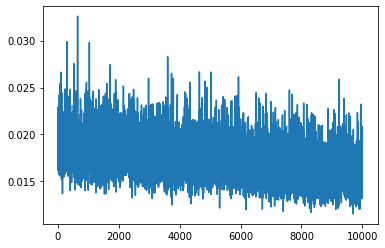

epoch: 12 	 step:0 	 loss: 0.01487 	 reg loss: 0.0008496
epoch: 12 	 step:100 	 loss: 0.01723 	 reg loss: 0.0008737
epoch: 12 	 step:200 	 loss: 0.01556 	 reg loss: 0.0008585
epoch: 12 	 step:300 	 loss: 0.01468 	 reg loss: 0.0008435
epoch: 12 	 step:400 	 loss: 0.01454 	 reg loss: 0.0008491
epoch: 12 	 step:500 	 loss: 0.01443 	 reg loss: 0.0008706
epoch: 12 	 step:600 	 loss: 0.01629 	 reg loss: 0.0008758
epoch: 12 	 step:700 	 loss: 0.01441 	 reg loss: 0.0008661
epoch: 12 	 step:800 	 loss: 0.0141 	 reg loss: 0.0008477
epoch: 12 	 step:900 	 loss: 0.01363 	 reg loss: 0.0008424
epoch: 12 	 step:1000 	 loss: 0.01461 	 reg loss: 0.0008709
epoch: 12 	 step:1100 	 loss: 0.01593 	 reg loss: 0.0008534
epoch: 12 	 step:1200 	 loss: 0.01396 	 reg loss: 0.0008521
epoch: 12 	 step:1300 	 loss: 0.0137 	 reg loss: 0.0008575
epoch: 12 	 step:1400 	 loss: 0.01349 	 reg loss: 0.0008425
epoch: 12 	 step:1500 	 loss: 0.01404 	 reg loss: 0.0008667
epoch: 12 	 step:1600 	 loss: 0.01573 	 reg loss: 0.00

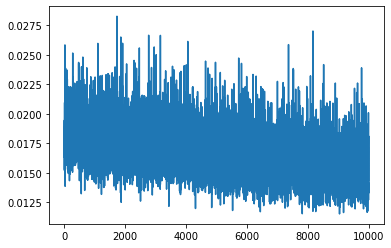

epoch: 13 	 step:0 	 loss: 0.01668 	 reg loss: 0.0008512
epoch: 13 	 step:100 	 loss: 0.01444 	 reg loss: 0.0008429
epoch: 13 	 step:200 	 loss: 0.01282 	 reg loss: 0.0008411
epoch: 13 	 step:300 	 loss: 0.01517 	 reg loss: 0.0008477
epoch: 13 	 step:400 	 loss: 0.0155 	 reg loss: 0.0008438
epoch: 13 	 step:500 	 loss: 0.01485 	 reg loss: 0.0008932
epoch: 13 	 step:600 	 loss: 0.01503 	 reg loss: 0.0008694
epoch: 13 	 step:700 	 loss: 0.01521 	 reg loss: 0.0008577
epoch: 13 	 step:800 	 loss: 0.01711 	 reg loss: 0.0008849
epoch: 13 	 step:900 	 loss: 0.01404 	 reg loss: 0.0008567
epoch: 13 	 step:1000 	 loss: 0.01233 	 reg loss: 0.0008736
epoch: 13 	 step:1100 	 loss: 0.01518 	 reg loss: 0.0008927
epoch: 13 	 step:1200 	 loss: 0.01497 	 reg loss: 0.0008968
epoch: 13 	 step:1300 	 loss: 0.01481 	 reg loss: 0.0008953
epoch: 13 	 step:1400 	 loss: 0.01468 	 reg loss: 0.0008804
epoch: 13 	 step:1500 	 loss: 0.01301 	 reg loss: 0.0008799
epoch: 13 	 step:1600 	 loss: 0.01239 	 reg loss: 0.0

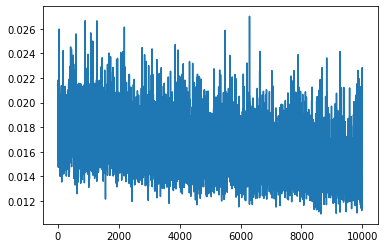

epoch: 14 	 step:0 	 loss: 0.01541 	 reg loss: 0.0009274
epoch: 14 	 step:100 	 loss: 0.01458 	 reg loss: 0.0008994
epoch: 14 	 step:200 	 loss: 0.01643 	 reg loss: 0.0009129
epoch: 14 	 step:300 	 loss: 0.01552 	 reg loss: 0.0008904
epoch: 14 	 step:400 	 loss: 0.01405 	 reg loss: 0.0009225
epoch: 14 	 step:500 	 loss: 0.01583 	 reg loss: 0.000898
epoch: 14 	 step:600 	 loss: 0.01714 	 reg loss: 0.0009389
epoch: 14 	 step:700 	 loss: 0.01347 	 reg loss: 0.0009136
epoch: 14 	 step:800 	 loss: 0.01443 	 reg loss: 0.0009143
epoch: 14 	 step:900 	 loss: 0.01298 	 reg loss: 0.0009072
epoch: 14 	 step:1000 	 loss: 0.01382 	 reg loss: 0.0009128
epoch: 14 	 step:1100 	 loss: 0.01329 	 reg loss: 0.0009406
epoch: 14 	 step:1200 	 loss: 0.01176 	 reg loss: 0.0009153
epoch: 14 	 step:1300 	 loss: 0.01258 	 reg loss: 0.000911
epoch: 14 	 step:1400 	 loss: 0.01405 	 reg loss: 0.0009652
epoch: 14 	 step:1500 	 loss: 0.01566 	 reg loss: 0.0009177
epoch: 14 	 step:1600 	 loss: 0.01646 	 reg loss: 0.00

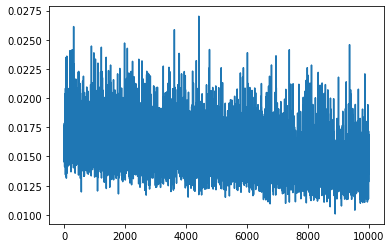

epoch: 15 	 step:0 	 loss: 0.0145 	 reg loss: 0.0009387
epoch: 15 	 step:100 	 loss: 0.01363 	 reg loss: 0.000931
epoch: 15 	 step:200 	 loss: 0.0134 	 reg loss: 0.0008937
epoch: 15 	 step:300 	 loss: 0.01351 	 reg loss: 0.0009081
epoch: 15 	 step:400 	 loss: 0.01505 	 reg loss: 0.0009124
epoch: 15 	 step:500 	 loss: 0.0143 	 reg loss: 0.0009488
epoch: 15 	 step:600 	 loss: 0.01398 	 reg loss: 0.0009227
epoch: 15 	 step:700 	 loss: 0.0124 	 reg loss: 0.000932
epoch: 15 	 step:800 	 loss: 0.01324 	 reg loss: 0.0009203
epoch: 15 	 step:900 	 loss: 0.01289 	 reg loss: 0.0009279
epoch: 15 	 step:1000 	 loss: 0.01332 	 reg loss: 0.0009351
epoch: 15 	 step:1100 	 loss: 0.01672 	 reg loss: 0.0009477
epoch: 15 	 step:1200 	 loss: 0.01413 	 reg loss: 0.0009249
epoch: 15 	 step:1300 	 loss: 0.01478 	 reg loss: 0.0009056
epoch: 15 	 step:1400 	 loss: 0.01393 	 reg loss: 0.0009215
epoch: 15 	 step:1500 	 loss: 0.01256 	 reg loss: 0.0008943
epoch: 15 	 step:1600 	 loss: 0.01416 	 reg loss: 0.000904

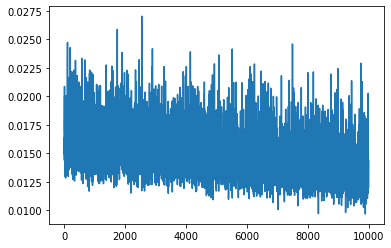

epoch: 16 	 step:0 	 loss: 0.01397 	 reg loss: 0.0009316
epoch: 16 	 step:100 	 loss: 0.01404 	 reg loss: 0.0009267
epoch: 16 	 step:200 	 loss: 0.01224 	 reg loss: 0.0009185
epoch: 16 	 step:300 	 loss: 0.01168 	 reg loss: 0.0009838
epoch: 16 	 step:400 	 loss: 0.01224 	 reg loss: 0.0009177
epoch: 16 	 step:500 	 loss: 0.01115 	 reg loss: 0.0009362
epoch: 16 	 step:600 	 loss: 0.01444 	 reg loss: 0.0009247
epoch: 16 	 step:700 	 loss: 0.01406 	 reg loss: 0.000934
epoch: 16 	 step:800 	 loss: 0.01277 	 reg loss: 0.0009026
epoch: 16 	 step:900 	 loss: 0.01299 	 reg loss: 0.0009278
epoch: 16 	 step:1000 	 loss: 0.01351 	 reg loss: 0.0009481
epoch: 16 	 step:1100 	 loss: 0.01364 	 reg loss: 0.0009081
epoch: 16 	 step:1200 	 loss: 0.01491 	 reg loss: 0.0009205
epoch: 16 	 step:1300 	 loss: 0.01326 	 reg loss: 0.000917
epoch: 16 	 step:1400 	 loss: 0.01299 	 reg loss: 0.0008969
epoch: 16 	 step:1500 	 loss: 0.01239 	 reg loss: 0.0009063
epoch: 16 	 step:1600 	 loss: 0.01054 	 reg loss: 0.00

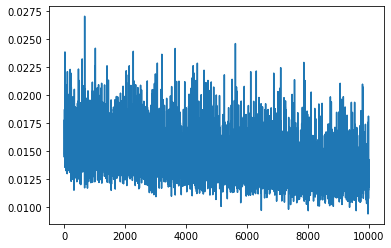

epoch: 17 	 step:0 	 loss: 0.01133 	 reg loss: 0.0008842
epoch: 17 	 step:100 	 loss: 0.01159 	 reg loss: 0.0008863
epoch: 17 	 step:200 	 loss: 0.01234 	 reg loss: 0.0008782
epoch: 17 	 step:300 	 loss: 0.01225 	 reg loss: 0.0009342
epoch: 17 	 step:400 	 loss: 0.01304 	 reg loss: 0.0008846
epoch: 17 	 step:500 	 loss: 0.01269 	 reg loss: 0.0008997
epoch: 17 	 step:600 	 loss: 0.01181 	 reg loss: 0.0009147
epoch: 17 	 step:700 	 loss: 0.01412 	 reg loss: 0.0009063
epoch: 17 	 step:800 	 loss: 0.01359 	 reg loss: 0.0009454
epoch: 17 	 step:900 	 loss: 0.01278 	 reg loss: 0.0008678
epoch: 17 	 step:1000 	 loss: 0.01249 	 reg loss: 0.0008853
epoch: 17 	 step:1100 	 loss: 0.01386 	 reg loss: 0.0009156
epoch: 17 	 step:1200 	 loss: 0.0118 	 reg loss: 0.0008859
epoch: 17 	 step:1300 	 loss: 0.01383 	 reg loss: 0.0008642
epoch: 17 	 step:1400 	 loss: 0.0118 	 reg loss: 0.0009094
epoch: 17 	 step:1500 	 loss: 0.01424 	 reg loss: 0.0009034
epoch: 17 	 step:1600 	 loss: 0.01438 	 reg loss: 0.00

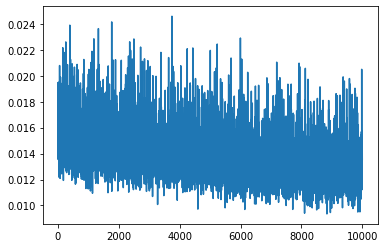

epoch: 18 	 step:0 	 loss: 0.01267 	 reg loss: 0.0008761
epoch: 18 	 step:100 	 loss: 0.01311 	 reg loss: 0.0008947
epoch: 18 	 step:200 	 loss: 0.01541 	 reg loss: 0.0008951
epoch: 18 	 step:300 	 loss: 0.01219 	 reg loss: 0.0009008
epoch: 18 	 step:400 	 loss: 0.01333 	 reg loss: 0.0008973
epoch: 18 	 step:500 	 loss: 0.01142 	 reg loss: 0.0008779
epoch: 18 	 step:600 	 loss: 0.01345 	 reg loss: 0.0008805
epoch: 18 	 step:700 	 loss: 0.01274 	 reg loss: 0.000902
epoch: 18 	 step:800 	 loss: 0.01267 	 reg loss: 0.0009005
epoch: 18 	 step:900 	 loss: 0.01245 	 reg loss: 0.0008879
epoch: 18 	 step:1000 	 loss: 0.01201 	 reg loss: 0.0008907
epoch: 18 	 step:1100 	 loss: 0.01447 	 reg loss: 0.0009203
epoch: 18 	 step:1200 	 loss: 0.01292 	 reg loss: 0.0008825
epoch: 18 	 step:1300 	 loss: 0.01265 	 reg loss: 0.0008924
epoch: 18 	 step:1400 	 loss: 0.01471 	 reg loss: 0.0008815
epoch: 18 	 step:1500 	 loss: 0.01247 	 reg loss: 0.0008812
epoch: 18 	 step:1600 	 loss: 0.01198 	 reg loss: 0.0

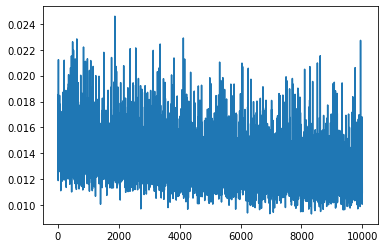

epoch: 19 	 step:0 	 loss: 0.01328 	 reg loss: 0.0008789
epoch: 19 	 step:100 	 loss: 0.01297 	 reg loss: 0.0008682
epoch: 19 	 step:200 	 loss: 0.0133 	 reg loss: 0.0008726
epoch: 19 	 step:300 	 loss: 0.009775 	 reg loss: 0.0008548
epoch: 19 	 step:400 	 loss: 0.01156 	 reg loss: 0.0008939
epoch: 19 	 step:500 	 loss: 0.01383 	 reg loss: 0.0008888
epoch: 19 	 step:600 	 loss: 0.01206 	 reg loss: 0.0008722
epoch: 19 	 step:700 	 loss: 0.01127 	 reg loss: 0.0008804
epoch: 19 	 step:800 	 loss: 0.01143 	 reg loss: 0.0008656
epoch: 19 	 step:900 	 loss: 0.01228 	 reg loss: 0.0008784
epoch: 19 	 step:1000 	 loss: 0.01191 	 reg loss: 0.0008522
epoch: 19 	 step:1100 	 loss: 0.01332 	 reg loss: 0.0008658
epoch: 19 	 step:1200 	 loss: 0.01189 	 reg loss: 0.0008841
epoch: 19 	 step:1300 	 loss: 0.01179 	 reg loss: 0.0008805
epoch: 19 	 step:1400 	 loss: 0.01366 	 reg loss: 0.0008882
epoch: 19 	 step:1500 	 loss: 0.01145 	 reg loss: 0.0008735
epoch: 19 	 step:1600 	 loss: 0.01019 	 reg loss: 0.

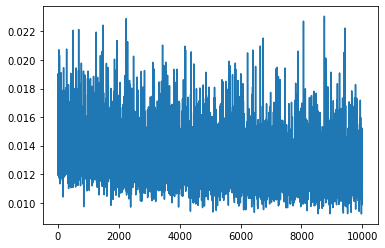

epoch: 20 	 step:0 	 loss: 0.01026 	 reg loss: 0.0008758
epoch: 20 	 step:100 	 loss: 0.01289 	 reg loss: 0.0008714
epoch: 20 	 step:200 	 loss: 0.01076 	 reg loss: 0.0008764
epoch: 20 	 step:300 	 loss: 0.009716 	 reg loss: 0.0008606
epoch: 20 	 step:400 	 loss: 0.01101 	 reg loss: 0.0008931
epoch: 20 	 step:500 	 loss: 0.008984 	 reg loss: 0.0008772
epoch: 20 	 step:600 	 loss: 0.01259 	 reg loss: 0.0008602
epoch: 20 	 step:700 	 loss: 0.01129 	 reg loss: 0.0008513
epoch: 20 	 step:800 	 loss: 0.01205 	 reg loss: 0.0008554
epoch: 20 	 step:900 	 loss: 0.01104 	 reg loss: 0.0008791
epoch: 20 	 step:1000 	 loss: 0.016 	 reg loss: 0.0008903
epoch: 20 	 step:1100 	 loss: 0.01182 	 reg loss: 0.0008888
epoch: 20 	 step:1200 	 loss: 0.01393 	 reg loss: 0.000898
epoch: 20 	 step:1300 	 loss: 0.01228 	 reg loss: 0.0008533
epoch: 20 	 step:1400 	 loss: 0.01097 	 reg loss: 0.000865
epoch: 20 	 step:1500 	 loss: 0.01191 	 reg loss: 0.000866
epoch: 20 	 step:1600 	 loss: 0.01195 	 reg loss: 0.000

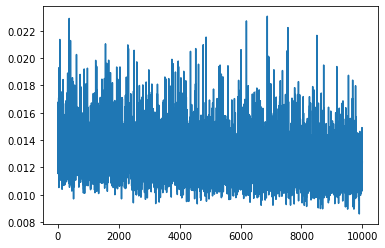

epoch: 21 	 step:0 	 loss: 0.01333 	 reg loss: 0.0008768
epoch: 21 	 step:100 	 loss: 0.01358 	 reg loss: 0.0008606
epoch: 21 	 step:200 	 loss: 0.0117 	 reg loss: 0.0008617
epoch: 21 	 step:300 	 loss: 0.01185 	 reg loss: 0.0008702
epoch: 21 	 step:400 	 loss: 0.01234 	 reg loss: 0.0008804
epoch: 21 	 step:500 	 loss: 0.01158 	 reg loss: 0.0008454
epoch: 21 	 step:600 	 loss: 0.01181 	 reg loss: 0.0008618
epoch: 21 	 step:700 	 loss: 0.01131 	 reg loss: 0.0008592
epoch: 21 	 step:800 	 loss: 0.01362 	 reg loss: 0.0008634
epoch: 21 	 step:900 	 loss: 0.009948 	 reg loss: 0.000857
epoch: 21 	 step:1000 	 loss: 0.0105 	 reg loss: 0.000869
epoch: 21 	 step:1100 	 loss: 0.01067 	 reg loss: 0.0008584
epoch: 21 	 step:1200 	 loss: 0.01109 	 reg loss: 0.0008712
epoch: 21 	 step:1300 	 loss: 0.01251 	 reg loss: 0.0008561
epoch: 21 	 step:1400 	 loss: 0.01088 	 reg loss: 0.0008688
epoch: 21 	 step:1500 	 loss: 0.009899 	 reg loss: 0.0008601
epoch: 21 	 step:1600 	 loss: 0.01153 	 reg loss: 0.00

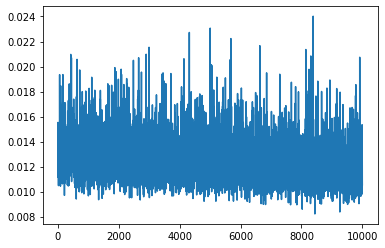

epoch: 22 	 step:0 	 loss: 0.01045 	 reg loss: 0.0008732
epoch: 22 	 step:100 	 loss: 0.0097 	 reg loss: 0.0008401
epoch: 22 	 step:200 	 loss: 0.01118 	 reg loss: 0.000877
epoch: 22 	 step:300 	 loss: 0.01116 	 reg loss: 0.0008789
epoch: 22 	 step:400 	 loss: 0.01015 	 reg loss: 0.0008649
epoch: 22 	 step:500 	 loss: 0.01089 	 reg loss: 0.0008561
epoch: 22 	 step:600 	 loss: 0.01232 	 reg loss: 0.000879
epoch: 22 	 step:700 	 loss: 0.01224 	 reg loss: 0.0008841
epoch: 22 	 step:800 	 loss: 0.01209 	 reg loss: 0.0008584
epoch: 22 	 step:900 	 loss: 0.011 	 reg loss: 0.0008743
epoch: 22 	 step:1000 	 loss: 0.01242 	 reg loss: 0.000877
epoch: 22 	 step:1100 	 loss: 0.01242 	 reg loss: 0.0008451
epoch: 22 	 step:1200 	 loss: 0.01102 	 reg loss: 0.0008721
epoch: 22 	 step:1300 	 loss: 0.01082 	 reg loss: 0.0008495
epoch: 22 	 step:1400 	 loss: 0.01427 	 reg loss: 0.0008846
epoch: 22 	 step:1500 	 loss: 0.01128 	 reg loss: 0.0008782
epoch: 22 	 step:1600 	 loss: 0.009702 	 reg loss: 0.00085

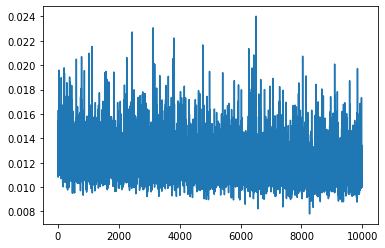

epoch: 23 	 step:0 	 loss: 0.01054 	 reg loss: 0.0008865
epoch: 23 	 step:100 	 loss: 0.01377 	 reg loss: 0.0008979
epoch: 23 	 step:200 	 loss: 0.01181 	 reg loss: 0.0008716
epoch: 23 	 step:300 	 loss: 0.0109 	 reg loss: 0.0008749
epoch: 23 	 step:400 	 loss: 0.01091 	 reg loss: 0.0008907
epoch: 23 	 step:500 	 loss: 0.01043 	 reg loss: 0.000873
epoch: 23 	 step:600 	 loss: 0.01103 	 reg loss: 0.0008786
epoch: 23 	 step:700 	 loss: 0.01249 	 reg loss: 0.0008558
epoch: 23 	 step:800 	 loss: 0.009287 	 reg loss: 0.0008635
epoch: 23 	 step:900 	 loss: 0.01362 	 reg loss: 0.0008955
epoch: 23 	 step:1000 	 loss: 0.01019 	 reg loss: 0.0008575
epoch: 23 	 step:1100 	 loss: 0.01229 	 reg loss: 0.0008858
epoch: 23 	 step:1200 	 loss: 0.01187 	 reg loss: 0.0008739
epoch: 23 	 step:1300 	 loss: 0.01101 	 reg loss: 0.0008903
epoch: 23 	 step:1400 	 loss: 0.01167 	 reg loss: 0.0008868
epoch: 23 	 step:1500 	 loss: 0.012 	 reg loss: 0.0009109
epoch: 23 	 step:1600 	 loss: 0.01164 	 reg loss: 0.000

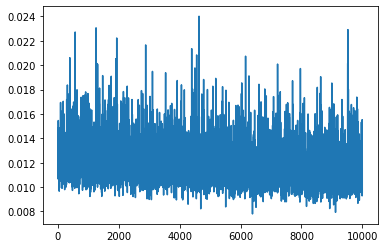

epoch: 24 	 step:0 	 loss: 0.01174 	 reg loss: 0.0009001
epoch: 24 	 step:100 	 loss: 0.01063 	 reg loss: 0.0008904
epoch: 24 	 step:200 	 loss: 0.01013 	 reg loss: 0.0008883
epoch: 24 	 step:300 	 loss: 0.008878 	 reg loss: 0.0008596
epoch: 24 	 step:400 	 loss: 0.01263 	 reg loss: 0.0009069
epoch: 24 	 step:500 	 loss: 0.01139 	 reg loss: 0.0008907
epoch: 24 	 step:600 	 loss: 0.01053 	 reg loss: 0.0008978
epoch: 24 	 step:700 	 loss: 0.009943 	 reg loss: 0.0008819
epoch: 24 	 step:800 	 loss: 0.01144 	 reg loss: 0.000906
epoch: 24 	 step:900 	 loss: 0.01144 	 reg loss: 0.0008903
epoch: 24 	 step:1000 	 loss: 0.01054 	 reg loss: 0.0008744
epoch: 24 	 step:1100 	 loss: 0.01066 	 reg loss: 0.0008609
epoch: 24 	 step:1200 	 loss: 0.009155 	 reg loss: 0.0008562
epoch: 24 	 step:1300 	 loss: 0.01094 	 reg loss: 0.0008933
epoch: 24 	 step:1400 	 loss: 0.0128 	 reg loss: 0.0008865
epoch: 24 	 step:1500 	 loss: 0.01031 	 reg loss: 0.0009022
epoch: 24 	 step:1600 	 loss: 0.01173 	 reg loss: 0

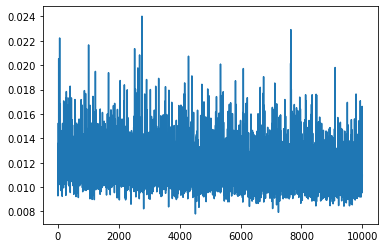

epoch: 25 	 step:0 	 loss: 0.01127 	 reg loss: 0.00091
epoch: 25 	 step:100 	 loss: 0.0128 	 reg loss: 0.0009023
epoch: 25 	 step:200 	 loss: 0.01137 	 reg loss: 0.0009125
epoch: 25 	 step:300 	 loss: 0.009966 	 reg loss: 0.000874
epoch: 25 	 step:400 	 loss: 0.008917 	 reg loss: 0.0008926
epoch: 25 	 step:500 	 loss: 0.01073 	 reg loss: 0.0008878
epoch: 25 	 step:600 	 loss: 0.01031 	 reg loss: 0.0008908
epoch: 25 	 step:700 	 loss: 0.01204 	 reg loss: 0.0008966
epoch: 25 	 step:800 	 loss: 0.01206 	 reg loss: 0.0008975
epoch: 25 	 step:900 	 loss: 0.01072 	 reg loss: 0.0008928
epoch: 25 	 step:1000 	 loss: 0.01337 	 reg loss: 0.0009131
epoch: 25 	 step:1100 	 loss: 0.009798 	 reg loss: 0.0008863
epoch: 25 	 step:1200 	 loss: 0.01151 	 reg loss: 0.0008857
epoch: 25 	 step:1300 	 loss: 0.009422 	 reg loss: 0.000857
epoch: 25 	 step:1400 	 loss: 0.01191 	 reg loss: 0.0009015
epoch: 25 	 step:1500 	 loss: 0.01008 	 reg loss: 0.0008814
epoch: 25 	 step:1600 	 loss: 0.0125 	 reg loss: 0.00

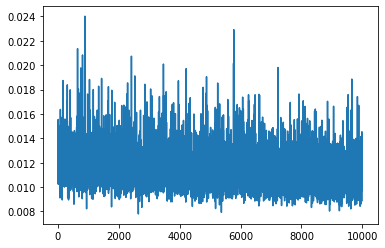

epoch: 26 	 step:0 	 loss: 0.008326 	 reg loss: 0.0008886
epoch: 26 	 step:100 	 loss: 0.01031 	 reg loss: 0.000903
epoch: 26 	 step:200 	 loss: 0.009717 	 reg loss: 0.0008888
epoch: 26 	 step:300 	 loss: 0.01099 	 reg loss: 0.0008816
epoch: 26 	 step:400 	 loss: 0.0129 	 reg loss: 0.0009479
epoch: 26 	 step:500 	 loss: 0.01051 	 reg loss: 0.0008805
epoch: 26 	 step:600 	 loss: 0.01072 	 reg loss: 0.0008971
epoch: 26 	 step:700 	 loss: 0.01089 	 reg loss: 0.0008973
epoch: 26 	 step:800 	 loss: 0.01148 	 reg loss: 0.0008995
epoch: 26 	 step:900 	 loss: 0.00944 	 reg loss: 0.0008807
epoch: 26 	 step:1000 	 loss: 0.01072 	 reg loss: 0.0008747
epoch: 26 	 step:1100 	 loss: 0.01562 	 reg loss: 0.0009307
epoch: 26 	 step:1200 	 loss: 0.01235 	 reg loss: 0.0009126
epoch: 26 	 step:1300 	 loss: 0.01074 	 reg loss: 0.0008885
epoch: 26 	 step:1400 	 loss: 0.0109 	 reg loss: 0.0008863
epoch: 26 	 step:1500 	 loss: 0.01194 	 reg loss: 0.0009039
epoch: 26 	 step:1600 	 loss: 0.009185 	 reg loss: 0.

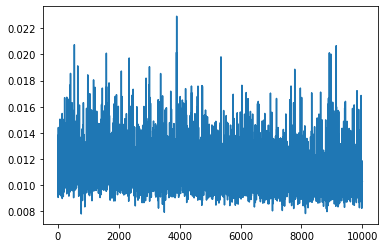

epoch: 27 	 step:0 	 loss: 0.01112 	 reg loss: 0.0009131
epoch: 27 	 step:100 	 loss: 0.01177 	 reg loss: 0.0008891
epoch: 27 	 step:200 	 loss: 0.009215 	 reg loss: 0.0008688
epoch: 27 	 step:300 	 loss: 0.01101 	 reg loss: 0.0008838
epoch: 27 	 step:400 	 loss: 0.009945 	 reg loss: 0.000894
epoch: 27 	 step:500 	 loss: 0.01169 	 reg loss: 0.0009017
epoch: 27 	 step:600 	 loss: 0.01172 	 reg loss: 0.00089
epoch: 27 	 step:700 	 loss: 0.009884 	 reg loss: 0.0009018
epoch: 27 	 step:800 	 loss: 0.01053 	 reg loss: 0.0008988
epoch: 27 	 step:900 	 loss: 0.01154 	 reg loss: 0.0008949
epoch: 27 	 step:1000 	 loss: 0.01054 	 reg loss: 0.000866
epoch: 27 	 step:1100 	 loss: 0.01232 	 reg loss: 0.000894
epoch: 27 	 step:1200 	 loss: 0.009311 	 reg loss: 0.0008891
epoch: 27 	 step:1300 	 loss: 0.01266 	 reg loss: 0.0008943
epoch: 27 	 step:1400 	 loss: 0.01079 	 reg loss: 0.0008823
epoch: 27 	 step:1500 	 loss: 0.01031 	 reg loss: 0.0008762
epoch: 27 	 step:1600 	 loss: 0.01053 	 reg loss: 0.0

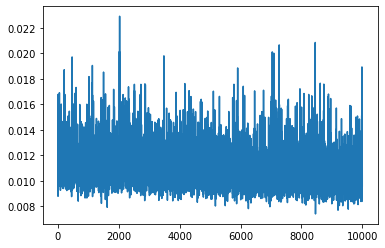

epoch: 28 	 step:0 	 loss: 0.01668 	 reg loss: 0.0009225
epoch: 28 	 step:100 	 loss: 0.01001 	 reg loss: 0.0008948
epoch: 28 	 step:200 	 loss: 0.01245 	 reg loss: 0.0008855
epoch: 28 	 step:300 	 loss: 0.009902 	 reg loss: 0.0008743
epoch: 28 	 step:400 	 loss: 0.01109 	 reg loss: 0.000902
epoch: 28 	 step:500 	 loss: 0.009145 	 reg loss: 0.0008806
epoch: 28 	 step:600 	 loss: 0.01116 	 reg loss: 0.0008885
epoch: 28 	 step:700 	 loss: 0.01015 	 reg loss: 0.0008626
epoch: 28 	 step:800 	 loss: 0.01002 	 reg loss: 0.0008795
epoch: 28 	 step:900 	 loss: 0.009976 	 reg loss: 0.0008837
epoch: 28 	 step:1000 	 loss: 0.01131 	 reg loss: 0.0008798
epoch: 28 	 step:1100 	 loss: 0.01221 	 reg loss: 0.0008731
epoch: 28 	 step:1200 	 loss: 0.01015 	 reg loss: 0.0008761
epoch: 28 	 step:1300 	 loss: 0.009957 	 reg loss: 0.0009019
epoch: 28 	 step:1400 	 loss: 0.01079 	 reg loss: 0.0009102
epoch: 28 	 step:1500 	 loss: 0.008591 	 reg loss: 0.000879
epoch: 28 	 step:1600 	 loss: 0.009735 	 reg loss

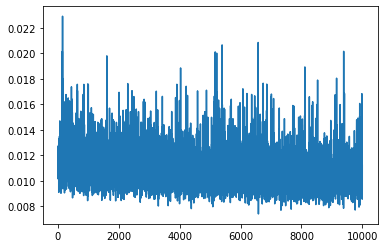

epoch: 29 	 step:0 	 loss: 0.01013 	 reg loss: 0.0008611
epoch: 29 	 step:100 	 loss: 0.01201 	 reg loss: 0.0008862
epoch: 29 	 step:200 	 loss: 0.01086 	 reg loss: 0.0008897
epoch: 29 	 step:300 	 loss: 0.01193 	 reg loss: 0.0008858
epoch: 29 	 step:400 	 loss: 0.00961 	 reg loss: 0.0008686
epoch: 29 	 step:500 	 loss: 0.009193 	 reg loss: 0.0008801
epoch: 29 	 step:600 	 loss: 0.008929 	 reg loss: 0.0008723
epoch: 29 	 step:700 	 loss: 0.01061 	 reg loss: 0.0008994
epoch: 29 	 step:800 	 loss: 0.01014 	 reg loss: 0.0009204
epoch: 29 	 step:900 	 loss: 0.009643 	 reg loss: 0.0008812
epoch: 29 	 step:1000 	 loss: 0.009618 	 reg loss: 0.0008838
epoch: 29 	 step:1100 	 loss: 0.0108 	 reg loss: 0.0008885
epoch: 29 	 step:1200 	 loss: 0.009447 	 reg loss: 0.0008915
epoch: 29 	 step:1300 	 loss: 0.01042 	 reg loss: 0.0008923
epoch: 29 	 step:1400 	 loss: 0.009165 	 reg loss: 0.0008595
epoch: 29 	 step:1500 	 loss: 0.00959 	 reg loss: 0.0008841
epoch: 29 	 step:1600 	 loss: 0.01036 	 reg los

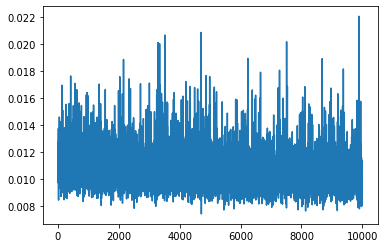

epoch: 30 	 step:0 	 loss: 0.00734 	 reg loss: 0.00089
epoch: 30 	 step:100 	 loss: 0.008522 	 reg loss: 0.0008946
epoch: 30 	 step:200 	 loss: 0.01204 	 reg loss: 0.0009016
epoch: 30 	 step:300 	 loss: 0.01236 	 reg loss: 0.0009051
epoch: 30 	 step:400 	 loss: 0.009682 	 reg loss: 0.0008729
epoch: 30 	 step:500 	 loss: 0.00892 	 reg loss: 0.0008798
epoch: 30 	 step:600 	 loss: 0.009411 	 reg loss: 0.0008721
epoch: 30 	 step:700 	 loss: 0.009026 	 reg loss: 0.0008914
epoch: 30 	 step:800 	 loss: 0.01087 	 reg loss: 0.0008929
epoch: 30 	 step:900 	 loss: 0.009681 	 reg loss: 0.0008967
epoch: 30 	 step:1000 	 loss: 0.01127 	 reg loss: 0.0008772
epoch: 30 	 step:1100 	 loss: 0.01094 	 reg loss: 0.0008597
epoch: 30 	 step:1200 	 loss: 0.01051 	 reg loss: 0.0008868
epoch: 30 	 step:1300 	 loss: 0.01071 	 reg loss: 0.0008774
epoch: 30 	 step:1400 	 loss: 0.01088 	 reg loss: 0.0008815
epoch: 30 	 step:1500 	 loss: 0.0115 	 reg loss: 0.0008798
epoch: 30 	 step:1600 	 loss: 0.01071 	 reg loss: 

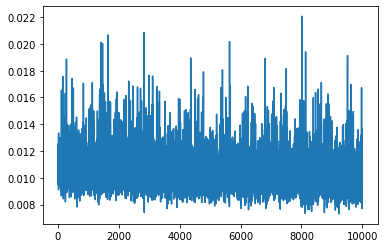

epoch: 31 	 step:0 	 loss: 0.009216 	 reg loss: 0.0008868
epoch: 31 	 step:100 	 loss: 0.009695 	 reg loss: 0.0008897
epoch: 31 	 step:200 	 loss: 0.009107 	 reg loss: 0.0008791
epoch: 31 	 step:300 	 loss: 0.01319 	 reg loss: 0.0009353
epoch: 31 	 step:400 	 loss: 0.01103 	 reg loss: 0.0009298
epoch: 31 	 step:500 	 loss: 0.009937 	 reg loss: 0.0009112
epoch: 31 	 step:600 	 loss: 0.009691 	 reg loss: 0.0008553
epoch: 31 	 step:700 	 loss: 0.009874 	 reg loss: 0.0008667
epoch: 31 	 step:800 	 loss: 0.009947 	 reg loss: 0.0009016
epoch: 31 	 step:900 	 loss: 0.008077 	 reg loss: 0.0008774
epoch: 31 	 step:1000 	 loss: 0.01077 	 reg loss: 0.0008779
epoch: 31 	 step:1100 	 loss: 0.0126 	 reg loss: 0.0008814
epoch: 31 	 step:1200 	 loss: 0.009937 	 reg loss: 0.0008709
epoch: 31 	 step:1300 	 loss: 0.01041 	 reg loss: 0.0008845
epoch: 31 	 step:1400 	 loss: 0.009118 	 reg loss: 0.0008689
epoch: 31 	 step:1500 	 loss: 0.009855 	 reg loss: 0.0008833
epoch: 31 	 step:1600 	 loss: 0.01025 	 re

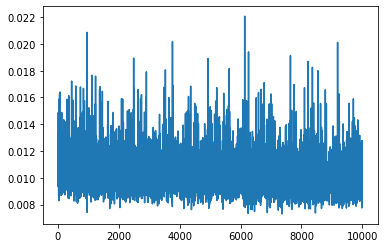

epoch: 32 	 step:0 	 loss: 0.008001 	 reg loss: 0.0008839
epoch: 32 	 step:100 	 loss: 0.009147 	 reg loss: 0.0008959
epoch: 32 	 step:200 	 loss: 0.009695 	 reg loss: 0.0008862
epoch: 32 	 step:300 	 loss: 0.01015 	 reg loss: 0.0008614
epoch: 32 	 step:400 	 loss: 0.009878 	 reg loss: 0.0008786
epoch: 32 	 step:500 	 loss: 0.009281 	 reg loss: 0.0008786
epoch: 32 	 step:600 	 loss: 0.008058 	 reg loss: 0.0008875
epoch: 32 	 step:700 	 loss: 0.01053 	 reg loss: 0.0009111
epoch: 32 	 step:800 	 loss: 0.009307 	 reg loss: 0.0008818
epoch: 32 	 step:900 	 loss: 0.009189 	 reg loss: 0.0008701
epoch: 32 	 step:1000 	 loss: 0.0102 	 reg loss: 0.0008927
epoch: 32 	 step:1100 	 loss: 0.009682 	 reg loss: 0.0009038
epoch: 32 	 step:1200 	 loss: 0.008269 	 reg loss: 0.0008696
epoch: 32 	 step:1300 	 loss: 0.007591 	 reg loss: 0.0008625
epoch: 32 	 step:1400 	 loss: 0.01156 	 reg loss: 0.0008945
epoch: 32 	 step:1500 	 loss: 0.01086 	 reg loss: 0.0008883
epoch: 32 	 step:1600 	 loss: 0.01034 	 re

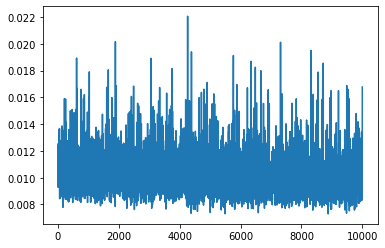

epoch: 33 	 step:0 	 loss: 0.008833 	 reg loss: 0.0008781
epoch: 33 	 step:100 	 loss: 0.01072 	 reg loss: 0.0008809
epoch: 33 	 step:200 	 loss: 0.009287 	 reg loss: 0.0008636
epoch: 33 	 step:300 	 loss: 0.008892 	 reg loss: 0.0008881
epoch: 33 	 step:400 	 loss: 0.01066 	 reg loss: 0.0008821
epoch: 33 	 step:500 	 loss: 0.00907 	 reg loss: 0.0008745
epoch: 33 	 step:600 	 loss: 0.008275 	 reg loss: 0.0009021
epoch: 33 	 step:700 	 loss: 0.009114 	 reg loss: 0.0008793
epoch: 33 	 step:800 	 loss: 0.01083 	 reg loss: 0.0009163
epoch: 33 	 step:900 	 loss: 0.009492 	 reg loss: 0.0008796
epoch: 33 	 step:1000 	 loss: 0.009436 	 reg loss: 0.0008693
epoch: 33 	 step:1100 	 loss: 0.009751 	 reg loss: 0.0008731
epoch: 33 	 step:1200 	 loss: 0.009694 	 reg loss: 0.0008893
epoch: 33 	 step:1300 	 loss: 0.01081 	 reg loss: 0.000872
epoch: 33 	 step:1400 	 loss: 0.01028 	 reg loss: 0.0009042
epoch: 33 	 step:1500 	 loss: 0.01064 	 reg loss: 0.0008848
epoch: 33 	 step:1600 	 loss: 0.009586 	 reg

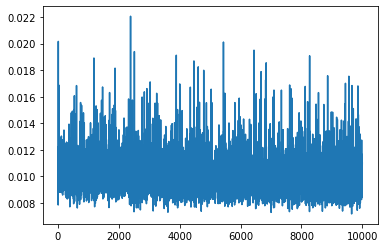

epoch: 34 	 step:0 	 loss: 0.01123 	 reg loss: 0.0009067
epoch: 34 	 step:100 	 loss: 0.009718 	 reg loss: 0.0008697
epoch: 34 	 step:200 	 loss: 0.009398 	 reg loss: 0.0009029
epoch: 34 	 step:300 	 loss: 0.009745 	 reg loss: 0.0008776
epoch: 34 	 step:400 	 loss: 0.009117 	 reg loss: 0.0008778
epoch: 34 	 step:500 	 loss: 0.01153 	 reg loss: 0.0008918
epoch: 34 	 step:600 	 loss: 0.007465 	 reg loss: 0.0008751
epoch: 34 	 step:700 	 loss: 0.009247 	 reg loss: 0.0008918
epoch: 34 	 step:800 	 loss: 0.008706 	 reg loss: 0.0008617
epoch: 34 	 step:900 	 loss: 0.008968 	 reg loss: 0.0008911
epoch: 34 	 step:1000 	 loss: 0.01184 	 reg loss: 0.0009094
epoch: 34 	 step:1100 	 loss: 0.009416 	 reg loss: 0.0008896
epoch: 34 	 step:1200 	 loss: 0.01046 	 reg loss: 0.0008805
epoch: 34 	 step:1300 	 loss: 0.01033 	 reg loss: 0.0008931
epoch: 34 	 step:1400 	 loss: 0.009098 	 reg loss: 0.0008775
epoch: 34 	 step:1500 	 loss: 0.01004 	 reg loss: 0.0008843
epoch: 34 	 step:1600 	 loss: 0.009663 	 r

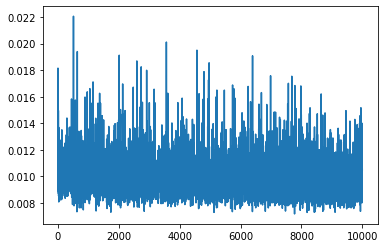

epoch: 35 	 step:0 	 loss: 0.0102 	 reg loss: 0.000868
epoch: 35 	 step:100 	 loss: 0.009489 	 reg loss: 0.0008598
epoch: 35 	 step:200 	 loss: 0.009546 	 reg loss: 0.0008864
epoch: 35 	 step:300 	 loss: 0.008423 	 reg loss: 0.0008751
epoch: 35 	 step:400 	 loss: 0.01015 	 reg loss: 0.0009148
epoch: 35 	 step:500 	 loss: 0.00953 	 reg loss: 0.0008872
epoch: 35 	 step:600 	 loss: 0.009953 	 reg loss: 0.0008886
epoch: 35 	 step:700 	 loss: 0.009018 	 reg loss: 0.0008758
epoch: 35 	 step:800 	 loss: 0.00967 	 reg loss: 0.0008693
epoch: 35 	 step:900 	 loss: 0.008934 	 reg loss: 0.0008563
epoch: 35 	 step:1000 	 loss: 0.01035 	 reg loss: 0.0008928
epoch: 35 	 step:1100 	 loss: 0.009847 	 reg loss: 0.0008781
epoch: 35 	 step:1200 	 loss: 0.008256 	 reg loss: 0.0008916
epoch: 35 	 step:1300 	 loss: 0.01132 	 reg loss: 0.0009117
epoch: 35 	 step:1400 	 loss: 0.009537 	 reg loss: 0.0008977
epoch: 35 	 step:1500 	 loss: 0.00987 	 reg loss: 0.0008675
epoch: 35 	 step:1600 	 loss: 0.008825 	 reg 

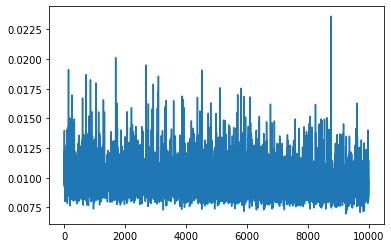

epoch: 36 	 step:0 	 loss: 0.009367 	 reg loss: 0.0008699
epoch: 36 	 step:100 	 loss: 0.008994 	 reg loss: 0.0008596
epoch: 36 	 step:200 	 loss: 0.008157 	 reg loss: 0.0008955
epoch: 36 	 step:300 	 loss: 0.00946 	 reg loss: 0.0008758
epoch: 36 	 step:400 	 loss: 0.008933 	 reg loss: 0.0008757
epoch: 36 	 step:500 	 loss: 0.01193 	 reg loss: 0.0009131
epoch: 36 	 step:600 	 loss: 0.01072 	 reg loss: 0.0008647
epoch: 36 	 step:700 	 loss: 0.00814 	 reg loss: 0.0008674
epoch: 36 	 step:800 	 loss: 0.008522 	 reg loss: 0.0008835
epoch: 36 	 step:900 	 loss: 0.007974 	 reg loss: 0.0008697
epoch: 36 	 step:1000 	 loss: 0.009468 	 reg loss: 0.0008932
epoch: 36 	 step:1100 	 loss: 0.01031 	 reg loss: 0.0008706
epoch: 36 	 step:1200 	 loss: 0.009915 	 reg loss: 0.0008743
epoch: 36 	 step:1300 	 loss: 0.01054 	 reg loss: 0.0008738
epoch: 36 	 step:1400 	 loss: 0.009427 	 reg loss: 0.0008769
epoch: 36 	 step:1500 	 loss: 0.009587 	 reg loss: 0.0008763
epoch: 36 	 step:1600 	 loss: 0.008882 	 r

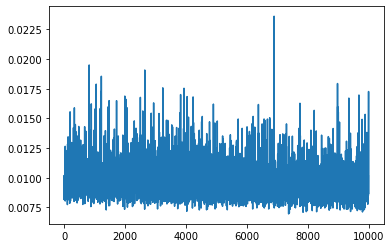

epoch: 37 	 step:0 	 loss: 0.00978 	 reg loss: 0.0008925
epoch: 37 	 step:100 	 loss: 0.009593 	 reg loss: 0.0008929
epoch: 37 	 step:200 	 loss: 0.009706 	 reg loss: 0.0008994
epoch: 37 	 step:300 	 loss: 0.008408 	 reg loss: 0.0008852
epoch: 37 	 step:400 	 loss: 0.009478 	 reg loss: 0.0008801
epoch: 37 	 step:500 	 loss: 0.00844 	 reg loss: 0.0008874
epoch: 37 	 step:600 	 loss: 0.00976 	 reg loss: 0.0008847
epoch: 37 	 step:700 	 loss: 0.008999 	 reg loss: 0.0008868
epoch: 37 	 step:800 	 loss: 0.009264 	 reg loss: 0.0008723
epoch: 37 	 step:900 	 loss: 0.009662 	 reg loss: 0.0008873
epoch: 37 	 step:1000 	 loss: 0.00919 	 reg loss: 0.000875
epoch: 37 	 step:1100 	 loss: 0.01059 	 reg loss: 0.0008869
epoch: 37 	 step:1200 	 loss: 0.009645 	 reg loss: 0.0008835
epoch: 37 	 step:1300 	 loss: 0.01094 	 reg loss: 0.0008685
epoch: 37 	 step:1400 	 loss: 0.009827 	 reg loss: 0.000885
epoch: 37 	 step:1500 	 loss: 0.00944 	 reg loss: 0.0008781
epoch: 37 	 step:1600 	 loss: 0.007805 	 reg 

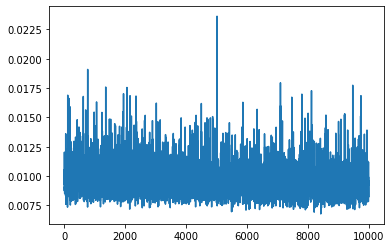

epoch: 38 	 step:0 	 loss: 0.009198 	 reg loss: 0.0008704
epoch: 38 	 step:100 	 loss: 0.007319 	 reg loss: 0.0008819
epoch: 38 	 step:200 	 loss: 0.007767 	 reg loss: 0.0008724
epoch: 38 	 step:300 	 loss: 0.008353 	 reg loss: 0.0008705
epoch: 38 	 step:400 	 loss: 0.008931 	 reg loss: 0.0008804
epoch: 38 	 step:500 	 loss: 0.01013 	 reg loss: 0.0008755
epoch: 38 	 step:600 	 loss: 0.008478 	 reg loss: 0.0008687
epoch: 38 	 step:700 	 loss: 0.0102 	 reg loss: 0.0008856
epoch: 38 	 step:800 	 loss: 0.008812 	 reg loss: 0.0008867
epoch: 38 	 step:900 	 loss: 0.01006 	 reg loss: 0.0008952
epoch: 38 	 step:1000 	 loss: 0.008586 	 reg loss: 0.0008695
epoch: 38 	 step:1100 	 loss: 0.008357 	 reg loss: 0.0008694
epoch: 38 	 step:1200 	 loss: 0.009088 	 reg loss: 0.0008734
epoch: 38 	 step:1300 	 loss: 0.007654 	 reg loss: 0.0008864
epoch: 38 	 step:1400 	 loss: 0.009787 	 reg loss: 0.0008586
epoch: 38 	 step:1500 	 loss: 0.009361 	 reg loss: 0.000892
epoch: 38 	 step:1600 	 loss: 0.01376 	 r

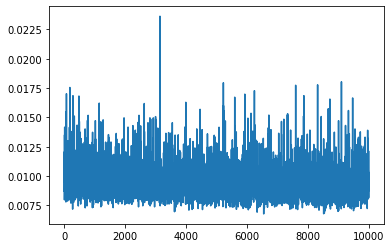

epoch: 39 	 step:0 	 loss: 0.008828 	 reg loss: 0.0008711
epoch: 39 	 step:100 	 loss: 0.007553 	 reg loss: 0.0008868
epoch: 39 	 step:200 	 loss: 0.007919 	 reg loss: 0.0008649
epoch: 39 	 step:300 	 loss: 0.008437 	 reg loss: 0.0008624
epoch: 39 	 step:400 	 loss: 0.009453 	 reg loss: 0.0008854
epoch: 39 	 step:500 	 loss: 0.0111 	 reg loss: 0.0008956
epoch: 39 	 step:600 	 loss: 0.008428 	 reg loss: 0.0008893
epoch: 39 	 step:700 	 loss: 0.008782 	 reg loss: 0.0008992
epoch: 39 	 step:800 	 loss: 0.008766 	 reg loss: 0.0008841
epoch: 39 	 step:900 	 loss: 0.009732 	 reg loss: 0.0008801
epoch: 39 	 step:1000 	 loss: 0.007606 	 reg loss: 0.0008857
epoch: 39 	 step:1100 	 loss: 0.009881 	 reg loss: 0.0008762
epoch: 39 	 step:1200 	 loss: 0.009181 	 reg loss: 0.0008758
epoch: 39 	 step:1300 	 loss: 0.01054 	 reg loss: 0.0008663
epoch: 39 	 step:1400 	 loss: 0.008248 	 reg loss: 0.0008748
epoch: 39 	 step:1500 	 loss: 0.01087 	 reg loss: 0.0008893
epoch: 39 	 step:1600 	 loss: 0.009189 	

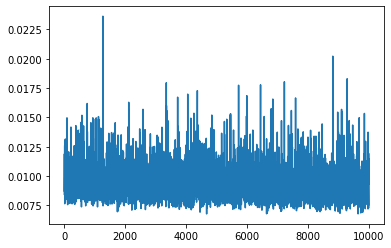

epoch: 40 	 step:0 	 loss: 0.009325 	 reg loss: 0.0008954
epoch: 40 	 step:100 	 loss: 0.01014 	 reg loss: 0.0008655
epoch: 40 	 step:200 	 loss: 0.008242 	 reg loss: 0.0008713
epoch: 40 	 step:300 	 loss: 0.008505 	 reg loss: 0.0008673
epoch: 40 	 step:400 	 loss: 0.008104 	 reg loss: 0.000891
epoch: 40 	 step:500 	 loss: 0.007784 	 reg loss: 0.000883
epoch: 40 	 step:600 	 loss: 0.007876 	 reg loss: 0.0008761
epoch: 40 	 step:700 	 loss: 0.007694 	 reg loss: 0.0008764
epoch: 40 	 step:800 	 loss: 0.009745 	 reg loss: 0.0008936
epoch: 40 	 step:900 	 loss: 0.007693 	 reg loss: 0.0008777
epoch: 40 	 step:1000 	 loss: 0.008725 	 reg loss: 0.0008718
epoch: 40 	 step:1100 	 loss: 0.009121 	 reg loss: 0.0008746
epoch: 40 	 step:1200 	 loss: 0.009234 	 reg loss: 0.000882
epoch: 40 	 step:1300 	 loss: 0.01027 	 reg loss: 0.0008809
epoch: 40 	 step:1400 	 loss: 0.008663 	 reg loss: 0.0008803
epoch: 40 	 step:1500 	 loss: 0.009048 	 reg loss: 0.0008809
epoch: 40 	 step:1600 	 loss: 0.00902 	 r

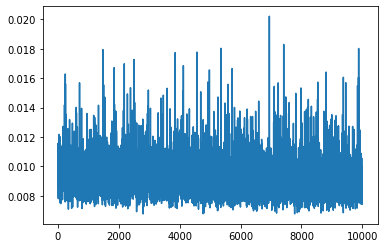

epoch: 41 	 step:0 	 loss: 0.008491 	 reg loss: 0.0008825
epoch: 41 	 step:100 	 loss: 0.0083 	 reg loss: 0.0008592
epoch: 41 	 step:200 	 loss: 0.008525 	 reg loss: 0.0008665
epoch: 41 	 step:300 	 loss: 0.009115 	 reg loss: 0.0008634
epoch: 41 	 step:400 	 loss: 0.008994 	 reg loss: 0.0008861
epoch: 41 	 step:500 	 loss: 0.01009 	 reg loss: 0.0008788
epoch: 41 	 step:600 	 loss: 0.01442 	 reg loss: 0.0009601
epoch: 41 	 step:700 	 loss: 0.00954 	 reg loss: 0.0008844
epoch: 41 	 step:800 	 loss: 0.008985 	 reg loss: 0.0008691
epoch: 41 	 step:900 	 loss: 0.01014 	 reg loss: 0.0009085
epoch: 41 	 step:1000 	 loss: 0.008774 	 reg loss: 0.0008548
epoch: 41 	 step:1100 	 loss: 0.009226 	 reg loss: 0.0008887
epoch: 41 	 step:1200 	 loss: 0.008596 	 reg loss: 0.0008685
epoch: 41 	 step:1300 	 loss: 0.007886 	 reg loss: 0.0008519
epoch: 41 	 step:1400 	 loss: 0.008083 	 reg loss: 0.0008813
epoch: 41 	 step:1500 	 loss: 0.008589 	 reg loss: 0.0008764
epoch: 41 	 step:1600 	 loss: 0.008014 	 r

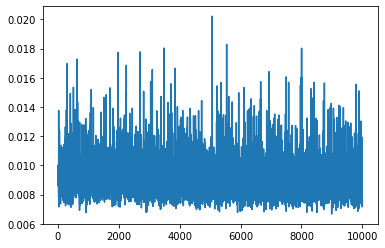

epoch: 42 	 step:0 	 loss: 0.008589 	 reg loss: 0.0008706
epoch: 42 	 step:100 	 loss: 0.007891 	 reg loss: 0.0008813
epoch: 42 	 step:200 	 loss: 0.008903 	 reg loss: 0.0008847
epoch: 42 	 step:300 	 loss: 0.01034 	 reg loss: 0.0009077
epoch: 42 	 step:400 	 loss: 0.008514 	 reg loss: 0.0008881
epoch: 42 	 step:500 	 loss: 0.00919 	 reg loss: 0.0008802
epoch: 42 	 step:600 	 loss: 0.00909 	 reg loss: 0.0008738
epoch: 42 	 step:700 	 loss: 0.009099 	 reg loss: 0.0008861
epoch: 42 	 step:800 	 loss: 0.009494 	 reg loss: 0.0008887
epoch: 42 	 step:900 	 loss: 0.008002 	 reg loss: 0.0008621
epoch: 42 	 step:1000 	 loss: 0.01034 	 reg loss: 0.0008761
epoch: 42 	 step:1100 	 loss: 0.00802 	 reg loss: 0.000872
epoch: 42 	 step:1200 	 loss: 0.008331 	 reg loss: 0.0008683
epoch: 42 	 step:1300 	 loss: 0.008865 	 reg loss: 0.0008757
epoch: 42 	 step:1400 	 loss: 0.008269 	 reg loss: 0.0008941
epoch: 42 	 step:1500 	 loss: 0.008114 	 reg loss: 0.0008922
epoch: 42 	 step:1600 	 loss: 0.00996 	 re

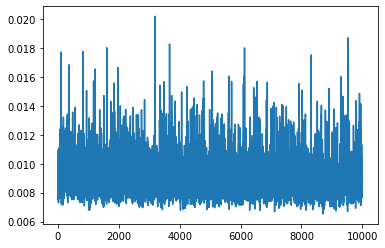

epoch: 43 	 step:0 	 loss: 0.008075 	 reg loss: 0.0008672
epoch: 43 	 step:100 	 loss: 0.008719 	 reg loss: 0.0008757
epoch: 43 	 step:200 	 loss: 0.01185 	 reg loss: 0.000894
epoch: 43 	 step:300 	 loss: 0.008452 	 reg loss: 0.0008776
epoch: 43 	 step:400 	 loss: 0.01142 	 reg loss: 0.0008878
epoch: 43 	 step:500 	 loss: 0.007889 	 reg loss: 0.0008693
epoch: 43 	 step:600 	 loss: 0.008579 	 reg loss: 0.0008724
epoch: 43 	 step:700 	 loss: 0.009713 	 reg loss: 0.0008886
epoch: 43 	 step:800 	 loss: 0.01203 	 reg loss: 0.0009598
epoch: 43 	 step:900 	 loss: 0.008602 	 reg loss: 0.000858
epoch: 43 	 step:1000 	 loss: 0.007565 	 reg loss: 0.0008633
epoch: 43 	 step:1100 	 loss: 0.008141 	 reg loss: 0.0008806
epoch: 43 	 step:1200 	 loss: 0.007516 	 reg loss: 0.0008727
epoch: 43 	 step:1300 	 loss: 0.009161 	 reg loss: 0.000881
epoch: 43 	 step:1400 	 loss: 0.008207 	 reg loss: 0.0008817
epoch: 43 	 step:1500 	 loss: 0.008784 	 reg loss: 0.0008643
epoch: 43 	 step:1600 	 loss: 0.01159 	 re

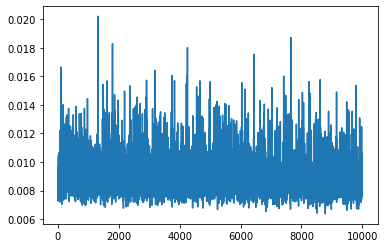

epoch: 44 	 step:0 	 loss: 0.009481 	 reg loss: 0.0008884
epoch: 44 	 step:100 	 loss: 0.01005 	 reg loss: 0.0008772
epoch: 44 	 step:200 	 loss: 0.008358 	 reg loss: 0.0008781
epoch: 44 	 step:300 	 loss: 0.01122 	 reg loss: 0.0009126
epoch: 44 	 step:400 	 loss: 0.008986 	 reg loss: 0.0008961
epoch: 44 	 step:500 	 loss: 0.009666 	 reg loss: 0.0008714
epoch: 44 	 step:600 	 loss: 0.007922 	 reg loss: 0.0008623
epoch: 44 	 step:700 	 loss: 0.009379 	 reg loss: 0.000894
epoch: 44 	 step:800 	 loss: 0.008362 	 reg loss: 0.0008647
epoch: 44 	 step:900 	 loss: 0.01119 	 reg loss: 0.0008751
epoch: 44 	 step:1000 	 loss: 0.01047 	 reg loss: 0.0008867
epoch: 44 	 step:1100 	 loss: 0.008667 	 reg loss: 0.0008753
epoch: 44 	 step:1200 	 loss: 0.008718 	 reg loss: 0.0008854
epoch: 44 	 step:1300 	 loss: 0.009562 	 reg loss: 0.0008737
epoch: 44 	 step:1400 	 loss: 0.009357 	 reg loss: 0.0008776
epoch: 44 	 step:1500 	 loss: 0.009193 	 reg loss: 0.0008752
epoch: 44 	 step:1600 	 loss: 0.009443 	 

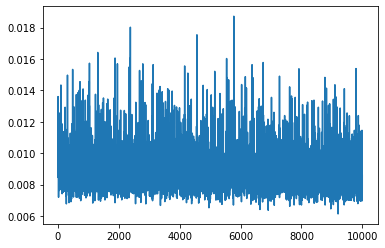

epoch: 45 	 step:0 	 loss: 0.008207 	 reg loss: 0.0008673
epoch: 45 	 step:100 	 loss: 0.008926 	 reg loss: 0.0008815
epoch: 45 	 step:200 	 loss: 0.009158 	 reg loss: 0.0008843
epoch: 45 	 step:300 	 loss: 0.009388 	 reg loss: 0.0008588
epoch: 45 	 step:400 	 loss: 0.008966 	 reg loss: 0.0008759
epoch: 45 	 step:500 	 loss: 0.008388 	 reg loss: 0.0008715
epoch: 45 	 step:600 	 loss: 0.009266 	 reg loss: 0.0008675
epoch: 45 	 step:700 	 loss: 0.008129 	 reg loss: 0.0008679
epoch: 45 	 step:800 	 loss: 0.01053 	 reg loss: 0.000876
epoch: 45 	 step:900 	 loss: 0.00856 	 reg loss: 0.0008788
epoch: 45 	 step:1000 	 loss: 0.01053 	 reg loss: 0.0008843
epoch: 45 	 step:1100 	 loss: 0.008516 	 reg loss: 0.0008885
epoch: 45 	 step:1200 	 loss: 0.007686 	 reg loss: 0.0008589
epoch: 45 	 step:1300 	 loss: 0.00883 	 reg loss: 0.0008798
epoch: 45 	 step:1400 	 loss: 0.008015 	 reg loss: 0.0008688
epoch: 45 	 step:1500 	 loss: 0.007358 	 reg loss: 0.0008761
epoch: 45 	 step:1600 	 loss: 0.008768 	 

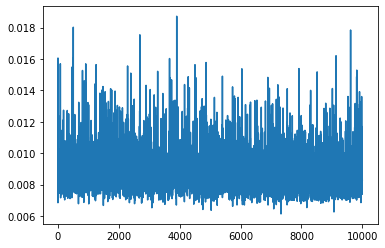

epoch: 46 	 step:0 	 loss: 0.008983 	 reg loss: 0.0008769
epoch: 46 	 step:100 	 loss: 0.008716 	 reg loss: 0.0008706
epoch: 46 	 step:200 	 loss: 0.009112 	 reg loss: 0.000904
epoch: 46 	 step:300 	 loss: 0.008813 	 reg loss: 0.0008845
epoch: 46 	 step:400 	 loss: 0.008158 	 reg loss: 0.0008857
epoch: 46 	 step:500 	 loss: 0.009324 	 reg loss: 0.0008749
epoch: 46 	 step:600 	 loss: 0.008514 	 reg loss: 0.0008752
epoch: 46 	 step:700 	 loss: 0.007594 	 reg loss: 0.0008728
epoch: 46 	 step:800 	 loss: 0.007815 	 reg loss: 0.0008676
epoch: 46 	 step:900 	 loss: 0.007798 	 reg loss: 0.0008613
epoch: 46 	 step:1000 	 loss: 0.00737 	 reg loss: 0.0008722
epoch: 46 	 step:1100 	 loss: 0.008355 	 reg loss: 0.0008771
epoch: 46 	 step:1200 	 loss: 0.009259 	 reg loss: 0.0008615
epoch: 46 	 step:1300 	 loss: 0.009088 	 reg loss: 0.0008408
epoch: 46 	 step:1400 	 loss: 0.007627 	 reg loss: 0.0008765
epoch: 46 	 step:1500 	 loss: 0.008524 	 reg loss: 0.0008635
epoch: 46 	 step:1600 	 loss: 0.009835

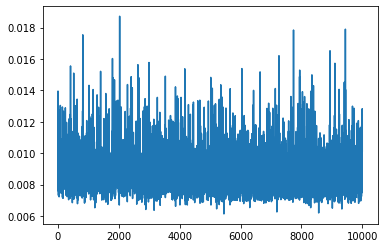

epoch: 47 	 step:0 	 loss: 0.007556 	 reg loss: 0.0008806
epoch: 47 	 step:100 	 loss: 0.008463 	 reg loss: 0.0008612
epoch: 47 	 step:200 	 loss: 0.008671 	 reg loss: 0.0008718
epoch: 47 	 step:300 	 loss: 0.009839 	 reg loss: 0.0008637
epoch: 47 	 step:400 	 loss: 0.007622 	 reg loss: 0.0008535
epoch: 47 	 step:500 	 loss: 0.009469 	 reg loss: 0.0008661
epoch: 47 	 step:600 	 loss: 0.008775 	 reg loss: 0.0008584
epoch: 47 	 step:700 	 loss: 0.007703 	 reg loss: 0.0008509
epoch: 47 	 step:800 	 loss: 0.007119 	 reg loss: 0.0008563
epoch: 47 	 step:900 	 loss: 0.00827 	 reg loss: 0.0008729
epoch: 47 	 step:1000 	 loss: 0.009741 	 reg loss: 0.0008567
epoch: 47 	 step:1100 	 loss: 0.009246 	 reg loss: 0.0008841
epoch: 47 	 step:1200 	 loss: 0.009312 	 reg loss: 0.0008836
epoch: 47 	 step:1300 	 loss: 0.008317 	 reg loss: 0.0008716
epoch: 47 	 step:1400 	 loss: 0.009768 	 reg loss: 0.0008688
epoch: 47 	 step:1500 	 loss: 0.008806 	 reg loss: 0.0008492
epoch: 47 	 step:1600 	 loss: 0.00765

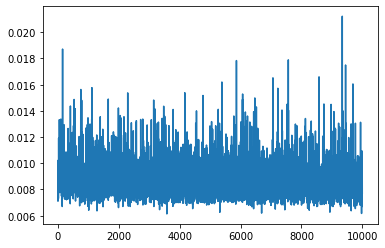

epoch: 48 	 step:0 	 loss: 0.007585 	 reg loss: 0.0008487
epoch: 48 	 step:100 	 loss: 0.01107 	 reg loss: 0.0008939
epoch: 48 	 step:200 	 loss: 0.008796 	 reg loss: 0.0009
epoch: 48 	 step:300 	 loss: 0.007219 	 reg loss: 0.0008569
epoch: 48 	 step:400 	 loss: 0.008083 	 reg loss: 0.0008602
epoch: 48 	 step:500 	 loss: 0.007906 	 reg loss: 0.0008594
epoch: 48 	 step:600 	 loss: 0.007457 	 reg loss: 0.0008648
epoch: 48 	 step:700 	 loss: 0.007352 	 reg loss: 0.0008416
epoch: 48 	 step:800 	 loss: 0.00773 	 reg loss: 0.0008434
epoch: 48 	 step:900 	 loss: 0.009492 	 reg loss: 0.0008727
epoch: 48 	 step:1000 	 loss: 0.009017 	 reg loss: 0.0008607
epoch: 48 	 step:1100 	 loss: 0.008468 	 reg loss: 0.0008789
epoch: 48 	 step:1200 	 loss: 0.00792 	 reg loss: 0.0008569
epoch: 48 	 step:1300 	 loss: 0.008231 	 reg loss: 0.0008488
epoch: 48 	 step:1400 	 loss: 0.007658 	 reg loss: 0.0008503
epoch: 48 	 step:1500 	 loss: 0.009006 	 reg loss: 0.0008777
epoch: 48 	 step:1600 	 loss: 0.009843 	 r

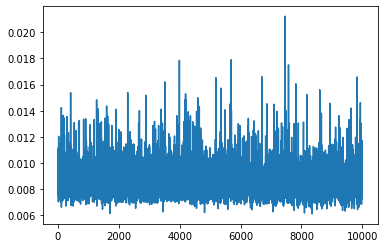

epoch: 49 	 step:0 	 loss: 0.00755 	 reg loss: 0.0008412
epoch: 49 	 step:100 	 loss: 0.008352 	 reg loss: 0.0008541
epoch: 49 	 step:200 	 loss: 0.009387 	 reg loss: 0.000843
epoch: 49 	 step:300 	 loss: 0.007618 	 reg loss: 0.000844
epoch: 49 	 step:400 	 loss: 0.01391 	 reg loss: 0.0009257
epoch: 49 	 step:500 	 loss: 0.009684 	 reg loss: 0.0008447
epoch: 49 	 step:600 	 loss: 0.008957 	 reg loss: 0.0008545
epoch: 49 	 step:700 	 loss: 0.008809 	 reg loss: 0.0008663
epoch: 49 	 step:800 	 loss: 0.007935 	 reg loss: 0.0008463
epoch: 49 	 step:900 	 loss: 0.008903 	 reg loss: 0.0008563
epoch: 49 	 step:1000 	 loss: 0.007559 	 reg loss: 0.0008352
epoch: 49 	 step:1100 	 loss: 0.01137 	 reg loss: 0.000916
epoch: 49 	 step:1200 	 loss: 0.007823 	 reg loss: 0.0008757
epoch: 49 	 step:1300 	 loss: 0.009315 	 reg loss: 0.0008488
epoch: 49 	 step:1400 	 loss: 0.008223 	 reg loss: 0.0008464
epoch: 49 	 step:1500 	 loss: 0.007714 	 reg loss: 0.0008611
epoch: 49 	 step:1600 	 loss: 0.007534 	 r

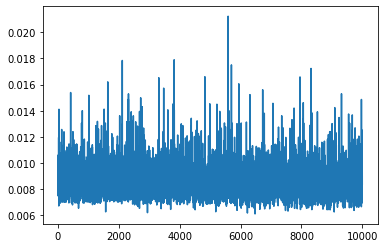

epoch: 50 	 step:0 	 loss: 0.007371 	 reg loss: 0.0008403
epoch: 50 	 step:100 	 loss: 0.008535 	 reg loss: 0.0008438
epoch: 50 	 step:200 	 loss: 0.008093 	 reg loss: 0.0008523
epoch: 50 	 step:300 	 loss: 0.007536 	 reg loss: 0.0008276
epoch: 50 	 step:400 	 loss: 0.00765 	 reg loss: 0.0008442
epoch: 50 	 step:500 	 loss: 0.008033 	 reg loss: 0.0008359
epoch: 50 	 step:600 	 loss: 0.007633 	 reg loss: 0.0008347
epoch: 50 	 step:700 	 loss: 0.008593 	 reg loss: 0.0008559
epoch: 50 	 step:800 	 loss: 0.008027 	 reg loss: 0.0008196
epoch: 50 	 step:900 	 loss: 0.007862 	 reg loss: 0.000861
epoch: 50 	 step:1000 	 loss: 0.008608 	 reg loss: 0.0008144
epoch: 50 	 step:1100 	 loss: 0.008214 	 reg loss: 0.0008479
epoch: 50 	 step:1200 	 loss: 0.0082 	 reg loss: 0.0008333
epoch: 50 	 step:1300 	 loss: 0.009685 	 reg loss: 0.0008482
epoch: 50 	 step:1400 	 loss: 0.007816 	 reg loss: 0.0008215
epoch: 50 	 step:1500 	 loss: 0.009257 	 reg loss: 0.0008356
epoch: 50 	 step:1600 	 loss: 0.007627 	

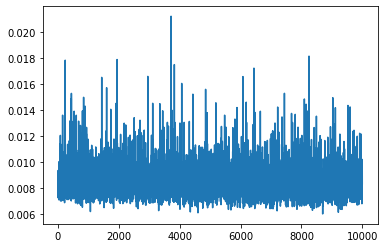

Avg loss last epoch: 0.008321399685988823


In [129]:
### TRAIN MODEL ###

num_epochs = 50

train_model(vae, optimizer, device, trainloader, epochs=num_epochs);

print("Avg loss last epoch:", np.mean(history[-len(history) // num_epochs:]))

In [130]:
### SAVE MODEL ###

model_weights = vae.state_dict().copy()
torch.save(model_weights, "../cache/models/VAE_MNIST/FCnet-VAE128Mnist.sd")

---

In [131]:
model_name = "FCnet-vae128"
z_size = 128
h_size = 2048

vae = SignalVAE(shape=imsize, latent_dim=z_size, hidden_dim=h_size)
#vae = models.SignalVAE(shape=imsize, latent_dim=z_size, hidden_dim=500)
vae.load_state_dict(torch.load("../cache/models/VAE_MNIST/FCnet-VAE128Mnist.sd"));

Version 4


In [132]:
# Latent z optimization

def genopt(sample_magn, vae, device, init_x=None, steps=5000, lmd=0.0, lr=1.0):
    
    vae.to(device)
    vae.eval()
    
    if init_x is None:
        # TODO: init like PRCGAN
        z = torch.randn((sample_magn.shape[0], z_size), requires_grad=True, device=device)
    else:
        z = vae.encoder(init_x).clone().detach().requires_grad_(True)
    
    opt = optim.Adam([z], lr=lr)
    
    losses = []
    errors = []
    last_out = vae.decoder(z)
    
    with tqdm(total=steps) as pbar:
        for _ in range(steps):
            magn = calc_mags(last_out)
            error = torch.mean((magn - sample_magn) ** 2, dim=(1, 2, 3))
            regul = torch.sum(z ** 2)
            loss = torch.sum(error) + lmd * regul

            opt.zero_grad()
            loss.backward()
            opt.step()

            last_out = vae.decoder(z)

            errors.append(error.detach().cpu().numpy())
            losses.append(loss.item())
            pbar.update()
    
    return last_out.detach().cpu().numpy(), errors

In [133]:
### Latent z optimization ###

num_batches = 4
batch_size = 256
steps = 10000
lmd = 0.0
lr = 1e-1
restarts = 3

###

out_original = np.zeros((batch_size * num_batches, *imsize))
out_results_total = np.zeros((batch_size * num_batches, restarts, *imsize))
errors = np.full((batch_size * num_batches, restarts, steps), np.inf)

with tqdm(total=restarts*num_batches) as pbar:
    for batch_i, batch in enumerate(dataloader['test']):
        test_sample = batch.to(device)
        test_magnitudes = calc_mags(test_sample)   
        out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()
        
        for rix in range(restarts):
            cur_out_results, cur_error = genopt(sample_magn=test_magnitudes, vae=vae, device=device,
                                                          steps=steps, lmd=lmd, lr=lr)

            out_results_total[batch_size * batch_i : batch_size * batch_i + batch_size, rix] = cur_out_results
            errors[batch_size * batch_i : batch_size * batch_i + batch_size, rix] = np.array(cur_error).T

            pbar.update()
        if batch_i + 1 >= num_batches:
            break
            
best_ix = np.argmin(errors[..., -1], axis=-1)
out_results = np.array([out_results_total[i, ix] for i, ix in enumerate(best_ix)])

In [134]:
### CACHE ERRORS ###

import pickle
pickle.dump(errors, open("../cache/dpr/err-dpr-{}-{}s-{}b.p".format(model_name, steps, num_batches), "wb"))

In [135]:
### LOAD ERRORS ###
import pickle

errors = pickle.load(open("../cache/dpr/err-dpr-{}-{}s-{}b.p".format(model_name, steps, num_batches), "rb"))

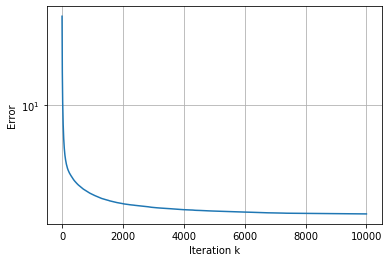

In [136]:
plt.xlabel("Iteration k")
plt.yscale('symlog')
plt.ylabel("Error")
plt.plot(np.mean(errors, axis=(0, 1)))
plt.grid(which='major')
plt.grid(which='minor')
plt.savefig("../out/plots/MNIST_DPR_error-{}-{}s-{}b.png".format(model_name, steps, num_batches), dpi=200)
plt.show()

In [137]:
### CACHE RESULTS ###

import pickle
pickle.dump(out_original, open("../cache/dpr/dpr-{}-{}s-{}b_original.p".format(model_name, steps, num_batches), "wb"))
pickle.dump(out_results, open("../cache/dpr/dpr-{}-{}s-{}b.p".format(model_name, steps, num_batches), "wb"))

In [138]:
### LOAD RESULTS ###
import pickle

out_original = pickle.load(open("../cache/dpr/dpr-{}-{}s-{}b_original.p".format(model_name, steps, num_batches), "rb"))
out_results = pickle.load(open("../cache/dpr/dpr-{}-{}s-{}b.p".format(model_name, steps, num_batches), "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


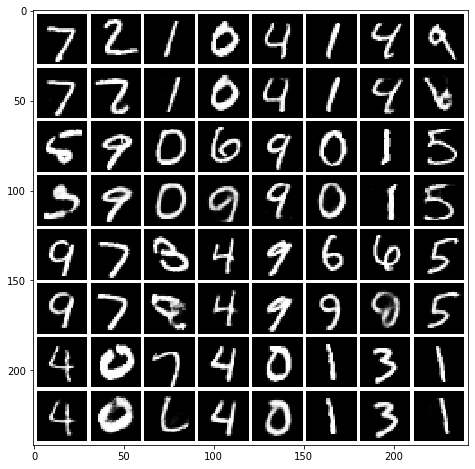

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Registered:


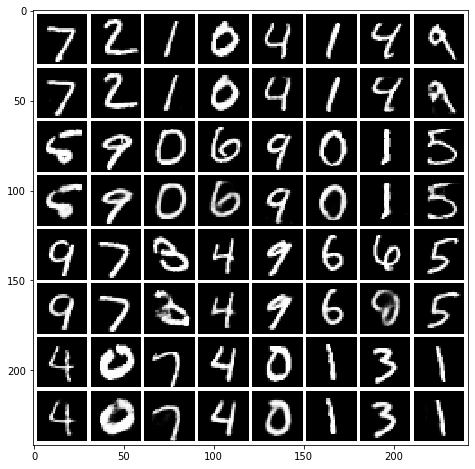

In [139]:
# Print predictions #
to_plot = np.stack([out_original[:32, 0].reshape(4, 8, 28, 28), 
                    out_results[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
plot_grid(to_plot, figsize=(8,8),file="../out/MNIST/generative-prior/dpr-{}-{}s-{}b.png"\
          .format(model_name, steps, num_batches))

print("Registered:")
results_reg = register_croco(out_results[:32], out_original[:32])
to_plot = np.stack([out_original[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)        
plot_grid(to_plot, figsize=(8,8), file="../out/MNIST/generative-prior/dpr-{}-{}s-{}b-reg.png"\
          .format(model_name, steps, num_batches))

In [140]:
# Benchmark test predictions #

benchmark(pred=out_results[:1024], true=out_original[:1024], check_all=True)

Signal error:
  MSE: 0.05491657071921935, std: 0.04671582651339367
  MAE: 0.08405956994677606, std: 0.05480676506936477
  SSIM: 0.6115555796537985, std: 0.2791385416401637
  Sharpness: 0.07012465415286748, std: 0.03862984317920925
  PhCo-MSE: 0.013552682826951257, std: 0.022870136247651558
  PhCo-MAE: 0.03401584373049655, std: 0.03082084108906404
  PhCo-SSIM: 0.8869555057774271, std: 0.1410811011202258
  CroCo-MSE: 0.011527021562633648, std: 0.016341790724770034
  CroCo-MAE: 0.03181922049171518, std: 0.024654497667033353
  CroCo-SSIM: 0.8959568764116622, std: 0.11977253705982271

Magnitude error:
  MSE Magnitude: 1.4922893361199046, std: 1.485810301996918

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.05492 | 0.08406 | 0.6116 | 0.07012 | 0.01355 | 0.03402 | 0.8870 | 0.01153 | 0.03182 | 0.8960 | 1.492 |


# VAE

### dim(z) = 128

| steps | lr | reg | MSE | MAE | SSIM | SHRP | PhCo-MSE | PhCo-MAE | PhCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 10000 | 0.1 | - | 0.05492 | 0.08406 | 0.6116 | 0.07012 | 0.01355 | 0.03402 | 0.8870 | 0.01153 | 0.03182 | 0.8960 | 1.492 |

Signal error:
  MSE: 0.05491657071921935, std: 0.04671582651339367
  MAE: 0.08405956994677606, std: 0.05480676506936477
  SSIM: 0.6115555796537985, std: 0.2791385416401637
  Sharpness: 0.07012465415286748, std: 0.03862984317920925
  PhCo-MSE: 0.013552682826951257, std: 0.022870136247651558
  PhCo-MAE: 0.03401584373049655, std: 0.03082084108906404
  PhCo-SSIM: 0.8869555057774271, std: 0.1410811011202258
  CroCo-MSE: 0.011527021562633648, std: 0.016341790724770034
  CroCo-MAE: 0.03181922049171518, std: 0.024654497667033353
  CroCo-SSIM: 0.8959568764116622, std: 0.11977253705982271

Magnitude error:
  MSE Magnitude: 1.4922893361199046, std: 1.485810301996918

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

# VAE small

### dim(z) = 784

| steps | lr | reg | MSE | MAE | SSIM | SHRP | PhCo-MSE | PhCo-MAE | PhCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 10000 | 0.1 | - | 0.08410 | 0.1147 | 0.4387 | 0.07737 | 0.02173 | 0.04130 | 0.8290 | 0.01793 | 0.03724 | 0.8456 | 1.067 |

Signal error:
  MSE: 0.084099660930537, std: 0.04739376236998848
  MAE: 0.11466768874790603, std: 0.05412426259526009
  SSIM: 0.4387281832331373, std: 0.26351725271361975
  Sharpness: 0.0773659926779479, std: 0.05817631523661649
  PhCo-MSE: 0.021731669454623837, std: 0.03284859003727328
  PhCo-MAE: 0.04130227612015311, std: 0.04374834105404472
  PhCo-SSIM: 0.8289667446482546, std: 0.21626499596646998
  CroCo-MSE: 0.017930003488915144, std: 0.024648892277310964
  CroCo-MAE: 0.03724265690859119, std: 0.03573234720648103
  CroCo-SSIM: 0.8456329701551111, std: 0.187831517910932

Magnitude error:
  MSE Magnitude: 1.0673149113320848, std: 1.2597462204305945

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

### dim(z) = 128

| steps | lr | reg | MSE | MAE | SSIM | SHRP | PhCo-MSE | PhCo-MAE | PhCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 0.1 | - | 0.09886 | 0.1407 | 0.2474 | 0.1583 | 0.09521 | 0.1372 | 0.3293 | 0.07327 | 0.1135 | 0.4083 | 21.05 |
| 10 | 0.1 | - | 0.09489 | 0.1327 | 0.3169 | 0.1435 | 0.07761 | 0.1139 | 0.4561 | 0.05676 | 0.09176 | 0.5358 | 9.883 |
| 25 | 0.1 | - | 0.09244 | 0.1264 | 0.3618 | 0.1305 | 0.05817 | 0.08910 | 0.5772 | 0.04418 | 0.07428 | 0.6347 | 5.815 |
| 100 | 0.1 | - | 0.08502 | 0.1169 | 0.4235 | 0.09851 | 0.03197 | 0.05683 | 0.7542 | 0.02557 | 0.05005 | 0.7813 | 2.232 |
| 500 | 0.1 | - | 0.08395 | 0.1150 | 0.4414 | 0.06972 | 0.01748 | 0.03622 | 0.8619 | 0.01441 | 0.03299 | 0.8749 | 0.9564 |
| 1000 | 0.1 | - | 0.08155 | 0.1121 | 0.4538 | 0.06250 | 0.01491 | 0.03185 | 0.8808 | 0.01236 | 0.02917 | 0.8916 | 0.7542 |
| 2000 | 0.1 | - | 0.08608 | 0.1167 | 0.4311 | 0.05746 | 0.01389 | 0.02935 | 0.8912 | 0.01152 | 0.02684 | 0.9019 | 0.6409 |
| 4000 | 0.1 | - | 0.08352 | 0.1138 | 0.4451 | 0.05111 | 0.01203 | 0.02608 | 0.9043 | 0.009754 | 0.02365 | 0.9145 | 0.5092 |
| 10000 | 0.1 | - | 0.08567 | 0.1156 | 0.4383 | 0.04748 | 0.01184 | 0.02462 | 0.9095 | 0.009836 | 0.02257 | 0.9173 | 0.4648 |

Signal error:
  MSE: 0.08566679786017092, std: 0.04860289221021634
  MAE: 0.11558568346932471, std: 0.05524226981453188
  SSIM: 0.4382694291937541, std: 0.26446020821706234
  Sharpness: 0.04747893084681998, std: 0.053088005553686826
  PhCo-MSE: 0.011839413455728488, std: 0.02728750554087527
  PhCo-MAE: 0.024618402939081255, std: 0.038102084201855645
  PhCo-SSIM: 0.9094943598334304, std: 0.17857658880571417
  CroCo-MSE: 0.009835640537078534, std: 0.020927644757885295
  CroCo-MAE: 0.0225735911843001, std: 0.032039658434490255
  CroCo-SSIM: 0.9172548665754576, std: 0.15767179270480713

Magnitude error:
  MSE Magnitude: 0.46482136585314615, std: 0.8001528428032155

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]


### dim(z) = 20

| steps | lr | reg | MSE | MAE | SSIM | SHRP | PhCo-MSE | PhCo-MAE | PhCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 10000 | 0.1 | - | 0.06056 | 0.09176 | 0.5678 | 0.08367 | 0.02060 | 0.04445 | 0.8282 | 0.01706 | 0.04057 | 0.8452 | 2.266 |

Signal error:
  MSE: 0.060563350723304876, std: 0.047310426138086906
  MAE: 0.09176174121694633, std: 0.05528467070047085
  SSIM: 0.5677791773794478, std: 0.2832566857697129
  Sharpness: 0.08367179059152774, std: 0.042454899142546125
  PhCo-MSE: 0.020598744040349528, std: 0.028017575373835476
  PhCo-MAE: 0.04445117013229796, std: 0.03639340534467959
  PhCo-SSIM: 0.8282016657719186, std: 0.1773826166661111
  CroCo-MSE: 0.01706110501969874, std: 0.02007026812133458
  CroCo-MAE: 0.04056950791721024, std: 0.028424065623157246
  CroCo-SSIM: 0.8452462033716317, std: 0.14784154330655214

Magnitude error:
  MSE Magnitude: 2.2661688433491407, std: 2.054193873660339

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]


## Out of distribution

In [8]:
model_name = "FCnet-vae128"
z_size = 128
h_size = 2048

vae = SignalVAE(shape=imsize, latent_dim=z_size, hidden_dim=h_size)
#vae = models.SignalVAE(shape=imsize, latent_dim=z_size, hidden_dim=500)
vae.load_state_dict(torch.load("../cache/models/VAE_MNIST/FCnet-VAE128Mnist.sd"));

Version 4


In [9]:
# Latent z optimization

def genopt(sample_magn, vae, device, init_x=None, steps=5000, lmd=0.0, lr=1.0):
    
    vae.to(device)
    vae.eval()
    
    if init_x is None:
        # TODO: init like PRCGAN
        z = torch.randn((sample_magn.shape[0], z_size), requires_grad=True, device=device)
    else:
        z = vae.encoder(init_x).clone().detach().requires_grad_(True)
    
    opt = optim.Adam([z], lr=lr)
    
    losses = []
    errors = []
    last_out = vae.decoder(z)
    
    with tqdm(total=steps) as pbar:
        for _ in range(steps):
            magn = calc_mags(last_out)
            error = torch.mean((magn - sample_magn) ** 2, dim=(1, 2, 3))
            regul = torch.sum(z ** 2)
            loss = torch.sum(error) + lmd * regul

            opt.zero_grad()
            loss.backward()
            opt.step()

            last_out = vae.decoder(z)

            errors.append(error.detach().cpu().numpy())
            losses.append(loss.item())
            pbar.update()
    
    return last_out.detach().cpu().numpy(), errors

In [27]:
# Helper functions

from PIL import Image

def unit(x, scale=1):
    _x = x ** scale
    _x = _x - np.minimum(np.min(_x), 0)
    return _x / np.max(_x)

def plot(x):
    plt.imshow(x, cmap="gray")
    plt.show()

def save_array(array, path):
    array = np.clip(array, 0.0, 1.0)
    plot(array)
    im = Image.fromarray((255 * array).astype('uint8'))
    im.save(path)

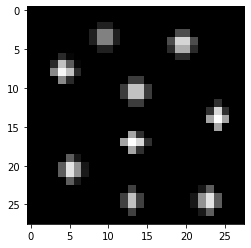

In [32]:
from skimage import io

name = "ood4"

ood_x = torch.tensor(io.imread('../data/ood/{}.png'.format(name), as_gray=True),
                    dtype = next(iter(dataloader['train'])).dtype)[None, None, ...]

plot(ood_x[0, 0])

In [33]:
### Latent z optimization ###

steps = 10000
lmd = 0.0
lr = 1e-1
restarts = 3

###

out_results_total = np.zeros((1, restarts, *imsize))
errors = np.full((1, restarts, steps), np.inf)

test_sample = ood_x.to(device)
test_magnitudes = calc_mags(test_sample)

for rix in range(restarts):
    cur_out_results, cur_error = genopt(sample_magn=test_magnitudes, vae=vae,
                                device=device, steps=steps, lmd=lmd, lr=lr)
    out_results_total[0, rix] = cur_out_results
    errors[0, rix] = np.array(cur_error).T
    
best_ix = np.argmin(errors[..., -1], axis=-1)
out_results = np.array([out_results_total[i, ix] for i, ix in enumerate(best_ix)])

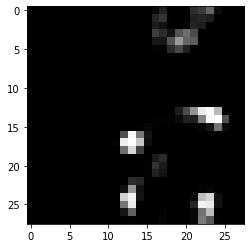

In [34]:
out_results_reg = register_croco(out_results, ood_x.numpy())[0, 0]
save_array(out_results_reg, "../out/ood/DPR_{}.png".format(name))

In [35]:
# Benchmark test predictions #

benchmark(pred=out_results, true=ood_x, check_all=True)

Signal error:
  MSE: 0.0520582577904811, std: 0.0
  MAE: 0.0860475777871197, std: 0.0
  SSIM: 0.01898666770028762, std: 0.0
  Sharpness: 0.0847498289756702, std: 0.0
  PhCo-MSE: 0.02027548775907274, std: 0.0
  PhCo-MAE: 0.047088182692753514, std: 0.0
  PhCo-SSIM: 0.4228060832671353, std: 0.0
  CroCo-MSE: 0.02027548775907274, std: 0.0
  CroCo-MAE: 0.047088182692753514, std: 0.0
  CroCo-SSIM: 0.4228060832671353, std: 0.0

Magnitude error:
  MSE Magnitude: 3.525286934483036, std: 0.0

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 0.99] - should be in [0, 1]

Markdown table values:
 0.05206 | 0.08605 | 0.01899 | 0.08475 | 0.02028 | 0.04709 | 0.4228 | 0.02028 | 0.04709 | 0.4228 | 3.525 |


/home/alobe101/.local/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:155: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


| Image | MSE | MAE | SSIM | SHRP | PhCo-MSE | PhCo-MAE | PhCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| ood1 | 0.01865 | 0.04747 | 0.8019 | 0.09625 | 0.02397 | 0.05080 | 0.7637 | 0.01744 | 0.04521 | 0.8177 | 2.793 |
| ood2 | 0.1245 | 0.1958 | 0.3626 | 0.1881 | 0.06055 | 0.1280 | 0.6181 | 0.05123 | 0.1120 | 0.6982 | 8.240 |
| ood3 | 0.04791 | 0.1096 | 0.4910 | 0.1143 | 0.04439 | 0.1062 | 0.5181 | 0.04226 | 0.1008 | 0.6015 | 7.452 |
| ood4 |  0.05206 | 0.08605 | 0.01899 | 0.08475 | 0.02028 | 0.04709 | 0.4228 | 0.02028 | 0.04709 | 0.4228 | 3.525 |

Signal error:
  MSE: 0.018647873007246782, std: 0.0
  MAE: 0.04747303653661551, std: 0.0
  SSIM: 0.8018975135374666, std: 0.0
  Sharpness: 0.0962542559934752, std: 0.0
  PhCo-MSE: 0.023967737642045326, std: 0.0
  PhCo-MAE: 0.05080007907495659, std: 0.0
  PhCo-SSIM: 0.7637072616750387, std: 0.0
  CroCo-MSE: 0.017443383672069542, std: 0.0
  CroCo-MAE: 0.04520553403913023, std: 0.0
  CroCo-SSIM: 0.8177018879471605, std: 0.0

Magnitude error:
  MSE Magnitude: 2.793051964939961, std: 0.0

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]
  
---

Signal error:
  MSE: 0.12445200974432145, std: 0.0
  MAE: 0.19581211013205044, std: 0.0
  SSIM: 0.3626252154702753, std: 0.0
  Sharpness: 0.18813855829442266, std: 0.0
  PhCo-MSE: 0.06055499691776978, std: 0.0
  PhCo-MAE: 0.12803383901951812, std: 0.0
  PhCo-SSIM: 0.6180729520331703, std: 0.0
  CroCo-MSE: 0.05122685407575193, std: 0.0
  CroCo-MAE: 0.11203901310203927, std: 0.0
  CroCo-SSIM: 0.6981587213611832, std: 0.0

Magnitude error:
  MSE Magnitude: 8.240428109945297, std: 0.0

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 0.99] - should be in [0, 1]
  
---

Signal error:
  MSE: 0.04790733796333632, std: 0.0
  MAE: 0.1095884021753672, std: 0.0
  SSIM: 0.4910489025194004, std: 0.0
  Sharpness: 0.11430336360233782, std: 0.0
  PhCo-MSE: 0.044387093616903794, std: 0.0
  PhCo-MAE: 0.10617133446952678, std: 0.0
  PhCo-SSIM: 0.5180508883114139, std: 0.0
  CroCo-MSE: 0.04226068650703804, std: 0.0
  CroCo-MAE: 0.10077002333924606, std: 0.0
  CroCo-SSIM: 0.6015374084270939, std: 0.0

Magnitude error:
  MSE Magnitude: 7.451713064660021, std: 0.0

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 0.94] - should be in [0, 1]
  
---

Signal error:
  MSE: 0.0520582577904811, std: 0.0
  MAE: 0.0860475777871197, std: 0.0
  SSIM: 0.01898666770028762, std: 0.0
  Sharpness: 0.0847498289756702, std: 0.0
  PhCo-MSE: 0.02027548775907274, std: 0.0
  PhCo-MAE: 0.047088182692753514, std: 0.0
  PhCo-SSIM: 0.4228060832671353, std: 0.0
  CroCo-MSE: 0.02027548775907274, std: 0.0
  CroCo-MAE: 0.047088182692753514, std: 0.0
  CroCo-SSIM: 0.4228060832671353, std: 0.0

Magnitude error:
  MSE Magnitude: 3.525286934483036, std: 0.0

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 0.99] - should be in [0, 1]